# Exploratory Data Analysis and Machine Learning Model to Predict Churn of Clients for a Telecom Operator

## Introduction

The telecom operator Interconnect would like to be able to forecast clients leaving, to offer promotional codes and special plan options in the hopes of retaining them. We are given information about their plans and contracts, types of payment chosen, type of contract (monthly payment or 1- or 2-year contract), Internet services and Landline option (multiple lines or not). The data goes up to February 1, 2020.

## Data Overview

### Imports

In [110]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [111]:
pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
Note: you may need to restart the kernel to use updated packages.


In [112]:
pip install -U ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
import seaborn as sns
import warnings
from pandas_profiling import ProfileReport
from datetime import datetime

from sklearn.preprocessing  import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [114]:
warnings.filterwarnings('ignore')

### Datasets First Look

In [115]:
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
except:
    print('Problem reading the csv file')

In [116]:
contract.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

In [117]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [118]:
try:
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
except:
    print('Problem reading the csv file')

In [119]:
internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [120]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [121]:
try:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
except:
    print('Problem reading the csv file')

In [122]:
personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [123]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [124]:
try:
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    print('Problem reading the csv file')

In [125]:
phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [126]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


### Conclusion

The contract dataset has 7043 entries and 8 variables, including the target variable `EndDate`. The quantitative variable `TotalCharges` will need to be converted to floats.
Internet dataset contains 5517 entries with 8 variables. Personal has 7043 entries with 5 variables. Phone dataset has 6361 entries of 2 variables. 

The variable `customerId` identifies each customer and won't be needed for the predictions, we have a column of dates `BeginDate` to be converted to pandas datetime and two quantitative variables `MonthlyCharges` and `TotalCharges`, the rest of the variables accross all datasets are categorical. 
At first glance, the target column to be predicted `EndDate` contains dates and the string 'No' so we will create a new target with binary categories instead, 1 for 'ended the contract', and 0 for 'is still on the contract'. 
We will make the columns names more consistent in the next section. None of the datasets seem to have missing values at first glance. We will also check uniques values in each column as well to see if there are any problematic entries, and also to look at the dates as it seems at first glance that all contracts start on the first of each month. 
It might be helpful to add a variable based on the month the contract started and see whether that influenced the target, or also the year it was started, but more importantly we think the length of time the contract has been effective might have a correlation too with the target so we will add that as well. 

We'll create also a new table with all the variables by merging all the datasets, but since they don't have the same number of entries this will add missing values in our data for those customers that did not subscribed to all the services. For the variables from the internet dataset, the strategy here that seems to make the most sense for us to fill in missing values would just to fill all those columns with 'No' value since those customers did not subscribe to those services and since we can use the column `InternetService` to indicate whether or not a customer got internet. However there is no such column in the phone dataset, and the only column from the phone dataset `MultipleLines` already has 'No' value as one of its categories to indicate just one line, so we would need to add another column just to indicate whether or not a customer subscribed to the telelphone services, otherwise just filling the missing values with 'No' might lead us to think that these customers had phone but just one line, and we will have to fill the `MultipleLines` missing entries with 'N/A' standing for 'Not Applicable' to distinguish them from 'No' there that just means only one line.

## Data Preprocessing

### Column Names

First we transform all column names to make them more consistent:

In [127]:
# Adding underscores between words and using lowercase for the column names

contract.columns = contract.columns.str.replace(r"([a-z])([A-Z])",r"\1_\2").str.lower()
internet.columns = internet.columns.str.replace(r"([a-z])([A-Z])",r"\1_\2").str.lower()
personal.columns = personal.columns.str.replace(r"([a-z])([A-Z])",r"\1_\2").str.lower()
phone.columns = phone.columns.str.replace(r"([a-z])([A-Z])",r"\1_\2").str.lower()

### Unique Values

Let's look at the unique values of each column to check for problematic entries and look at the begin dates:

In [128]:
pd.set_option('display.max_rows', None)

def check_unique_val(df, columns_list):
    '''Prints unique values of each column of a dataframe and their count
    
    df: dataframe
    columns_list: list of the column names of the dataframe to check for unique values
    '''
    
    for column in columns_list:
        print('Unique values of the column {} and their count: \n{}'
              .format(column, df[column].value_counts().sort_index()), end='\n'*2
             )
    
check_unique_val(contract, 
                 ['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method'])

Unique values of the column begin_date and their count: 
2013-10-01      3
2013-11-01      2
2013-12-01      3
2014-01-01      7
2014-02-01    366
2014-03-01    178
2014-04-01    114
2014-05-01     98
2014-06-01     97
2014-07-01     98
2014-08-01     82
2014-09-01     72
2014-10-01     80
2014-11-01     77
2014-12-01     75
2015-01-01     75
2015-02-01     80
2015-03-01     58
2015-04-01     69
2015-05-01     74
2015-06-01     79
2015-07-01     61
2015-08-01     66
2015-09-01     67
2015-10-01     81
2015-11-01     74
2015-12-01     68
2016-01-01     57
2016-02-01     73
2016-03-01     61
2016-04-01     73
2016-05-01     68
2016-06-01     59
2016-07-01     58
2016-08-01     67
2016-09-01     74
2016-10-01     65
2016-11-01     50
2016-12-01     58
2017-01-01     64
2017-02-01     55
2017-03-01     94
2017-04-01     66
2017-05-01     66
2017-06-01     62
2017-07-01     65
2017-08-01     71
2017-09-01     73
2017-10-01     57
2017-11-01     82
2017-12-01     90
2018-01-01     73
2018-02

In [129]:
check_unique_val(
    internet, 
    ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
)

Unique values of the column internet_service and their count: 
DSL            2421
Fiber optic    3096
Name: internet_service, dtype: int64

Unique values of the column online_security and their count: 
No     3498
Yes    2019
Name: online_security, dtype: int64

Unique values of the column online_backup and their count: 
No     3088
Yes    2429
Name: online_backup, dtype: int64

Unique values of the column device_protection and their count: 
No     3095
Yes    2422
Name: device_protection, dtype: int64

Unique values of the column tech_support and their count: 
No     3473
Yes    2044
Name: tech_support, dtype: int64

Unique values of the column streaming_tv and their count: 
No     2810
Yes    2707
Name: streaming_tv, dtype: int64

Unique values of the column streaming_movies and their count: 
No     2785
Yes    2732
Name: streaming_movies, dtype: int64



In [130]:
check_unique_val(personal, ['gender', 'senior_citizen', 'partner', 'dependents'])

Unique values of the column gender and their count: 
Female    3488
Male      3555
Name: gender, dtype: int64

Unique values of the column senior_citizen and their count: 
0    5901
1    1142
Name: senior_citizen, dtype: int64

Unique values of the column partner and their count: 
No     3641
Yes    3402
Name: partner, dtype: int64

Unique values of the column dependents and their count: 
No     4933
Yes    2110
Name: dependents, dtype: int64



In [131]:
check_unique_val(phone, ['multiple_lines'])

Unique values of the column multiple_lines and their count: 
No     3390
Yes    2971
Name: multiple_lines, dtype: int64



There is a clear imbalance in the target variable which might skew our model and make it predict customers staying much better than leaving, since customers that have ended their contract are less than half the ones that are still on it. Looking at unique values, we don't see any more problematic entries. The dates the contract begins are always on the first of each month, so only the month and year a contract started will be added to our dataset.

### Changing Data Types and Adding Columns

In [132]:
try:
    contract['begin_date'] = (
    pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')
    )
except:
    print('Error. Please check entries of column.')
contract.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date                     object
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges                object
dtype: object

In [133]:
# Adding month and year a contract started

contract['begin_month'] = pd.DatetimeIndex(contract['begin_date']).month
contract['begin_year'] = pd.DatetimeIndex(contract['begin_date']).year
contract.head()

customer_id begin_date             end_date            type  \
0  7590-VHVEG 2020-01-01                   No  Month-to-month   
1  5575-GNVDE 2017-04-01                   No        One year   
2  3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW 2016-05-01                   No        One year   
4  9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   

  paperless_billing             payment_method  monthly_charges total_charges  \
0               Yes           Electronic check            29.85         29.85   
1                No               Mailed check            56.95        1889.5   
2               Yes               Mailed check            53.85        108.15   
3                No  Bank transfer (automatic)            42.30       1840.75   
4               Yes           Electronic check            70.70        151.65   

   begin_month  begin_year  
0            1        2020  
1            4        2017  
2           10        2019  
3            5        2016  
4            9        2019

In [134]:
# Adding the length of time a contract has been effective. Since the date the data ends is 
# 2020-02-01, 2020 is just one month, and since the contracts start on the first each month,
# we need to also take into account that first month in the calculations.

def calculate_time(row):
    '''Calculates the length of time between either 2020-02 if end_date is 'No', or between 
    end_date and begin_year, begin_month otherwise.
    
    end_date: string of value 'No' or string of time format %Y-%m-%d %H:%M:%S
    begin_year: year (int)
    begin_month: month (int)
    '''
    if row['end_date'] == 'No':
        end_month = 2
        end_year = 2020
    else:
        end_date = datetime.strptime(row['end_date'], "%Y-%m-%d %H:%M:%S")
        end_month = end_date.month
        end_year = end_date.year
    return (end_year - row['begin_year']) * 12 + end_month - row['begin_month']

In [135]:
contract['contract_length'] = contract.apply(lambda row: calculate_time(row), axis=1)
contract.head()

customer_id begin_date             end_date            type  \
0  7590-VHVEG 2020-01-01                   No  Month-to-month   
1  5575-GNVDE 2017-04-01                   No        One year   
2  3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW 2016-05-01                   No        One year   
4  9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   

  paperless_billing             payment_method  monthly_charges total_charges  \
0               Yes           Electronic check            29.85         29.85   
1                No               Mailed check            56.95        1889.5   
2               Yes               Mailed check            53.85        108.15   
3                No  Bank transfer (automatic)            42.30       1840.75   
4               Yes           Electronic check            70.70        151.65   

   begin_month  begin_year  contract_length  
0            1        2020                1  
1            4        2017               34  
2           10        2019                2  
3            5        2016               45  
4            9        2019                2

In [136]:
# Converting total_charges to float, doing it on a copy in case there are problematic entries

contract_copy = contract.copy()
try:
    contract_copy['total_charges'] = pd.to_numeric(contract_copy['total_charges'], errors='coerce')
except:
    print('Error. Please check entries of column.')
    
contract_copy['total_charges'].isna().sum()

11

In [137]:
# Looking at original total_charges entry that wasn't converted to float above

for i in contract_copy[contract_copy['total_charges'].isna()].index:
    print(f"problematic entry at index {i}: '{contract.loc[i, 'total_charges']}', \
    monthly charge is: {contract.loc[i, 'monthly_charges']}")
print('Percentage of missing values: {:.2%}'.format(contract_copy['total_charges'].isna().sum()\
      / contract_copy.shape[0]))

problematic entry at index 488: ' ',     monthly charge is: 52.55
problematic entry at index 753: ' ',     monthly charge is: 20.25
problematic entry at index 936: ' ',     monthly charge is: 80.85
problematic entry at index 1082: ' ',     monthly charge is: 25.75
problematic entry at index 1340: ' ',     monthly charge is: 56.05
problematic entry at index 3331: ' ',     monthly charge is: 19.85
problematic entry at index 3826: ' ',     monthly charge is: 25.35
problematic entry at index 4380: ' ',     monthly charge is: 20.0
problematic entry at index 5218: ' ',     monthly charge is: 19.7
problematic entry at index 6670: ' ',     monthly charge is: 73.35
problematic entry at index 6754: ' ',     monthly charge is: 61.9
Percentage of missing values: 0.16%


There are 11 missing entries for `total_charges`. We could manually add them once we have calculated the length of those contracts, since those entries have monthly charges correct, but we are not exactly sure how total_charges are calculated since they are not exactly the monthly charges times the length of the contract. Since they represent less than 0.2% of the dataset, we will delete them for now (we might fill them if we get clarification on how the total charges are calculated).

### Profile Reports (missing values and duplicates check)

Let's look at missing values and duplicated ids in all datasets now:

In [138]:
profile = ProfileReport(contract_copy, title='Report for processed contract dataset',explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [139]:
profile = ProfileReport(internet, title='Report for internet dataset',explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [140]:
profile = ProfileReport(personal, title='Report for personal dataset',explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [141]:
profile = ProfileReport(phone, title='Report for phone dataset',explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

There are no missing values except for the 11 missing entries in `total_charges` we already saw, and no duplicated rows. We will go on to perform the exploratory data analysis after merging the tables together and filling the missing values.

### Merging Tables

In [142]:
# Checking first that all the customers in internet dataset are in the contract dataset

pd.merge(contract_copy, internet, how="inner", on=['customer_id']).shape[0] == internet.shape[0]

True

In [143]:
# Joining contract and internet together

contract_internet = pd.merge(contract_copy, internet, how="left", on=['customer_id'])
contract_internet.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
begin_month             0
begin_year              0
contract_length         0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
dtype: int64

In [144]:
# Checking we only introduced missing values corresponding to those that didn't purchase internet

contract_copy.shape[0] - internet.shape[0] == 1526

True

In [145]:
# Checking first that all the customers in personal dataset are in the contract dataset

pd.merge(contract_copy, personal, how="inner", on=['customer_id']).shape[0] == personal.shape[0]

True

In [146]:
# Joining contract_internet and personal together

contract_internet_perso = pd.merge(contract_internet, personal, how="left", on=['customer_id'])
contract_internet_perso.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
begin_month             0
begin_year              0
contract_length         0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
gender                  0
senior_citizen          0
partner                 0
dependents              0
dtype: int64

In [147]:
# Checking first that all the customers in phone dataset are in the contract dataset

pd.merge(contract_copy, phone, how="inner", on=['customer_id']).shape[0] == phone.shape[0]

True

In [148]:
# Joining contract_internet_perso and phone together

df = pd.merge(contract_internet_perso, phone, how="left", on=['customer_id'])
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
begin_month             0
begin_year              0
contract_length         0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
dtype: int64

In [149]:
# Adding a column to indicate whether a customer had subscribed to phone

df['phone'] = np.where(df['multiple_lines'].isna(), 0, 1)
df.head()

customer_id begin_date             end_date            type  \
0  7590-VHVEG 2020-01-01                   No  Month-to-month   
1  5575-GNVDE 2017-04-01                   No        One year   
2  3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW 2016-05-01                   No        One year   
4  9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   

  paperless_billing             payment_method  monthly_charges  \
0               Yes           Electronic check            29.85   
1                No               Mailed check            56.95   
2               Yes               Mailed check            53.85   
3                No  Bank transfer (automatic)            42.30   
4               Yes           Electronic check            70.70   

   total_charges  begin_month  begin_year  ...  device_protection  \
0          29.85            1        2020  ...                 No   
1        1889.50            4        2017  ...                Yes   
2         108.15           10        2019  ...                 No   
3        1840.75            5        2016  ...                Yes   
4         151.65            9        2019  ...                 No   

  tech_support streaming_tv streaming_movies  gender senior_citizen partner  \
0           No           No               No  Female              0     Yes   
1           No           No               No    Male              0      No   
2           No           No               No    Male              0      No   
3          Yes           No               No    Male              0      No   
4           No           No               No  Female              0      No   

  dependents multiple_lines  phone  
0         No            NaN      0  
1         No             No      1  
2         No             No      1  
3         No            NaN      0  
4         No             No      1  

[5 rows x 24 columns]

In [150]:
# Checking that the intersection of customers not having phone nor internet is empty
# as expected

df[(df['internet_service'].isna()) & (df['phone'] == 0)].shape[0]

0

### Handling missing values introduced during preprocessing

In [151]:
# Deleting the 11 entries missing in total_charges

df.dropna(subset=['total_charges'], inplace=True)

We will replace the missing values in `multiple_lines` with 'N/A' standing for 'Not Applicable' since those other entries represent customers that didn't purchase phone option, to distinguish with the 'No' there that just mean the customer got one line only.

In [152]:
# Replacing missing values in multiple_lines by N/A to indicate this variable doesn't apply to
# those customers that didn't purchase phone option

df.fillna({'multiple_lines':'N/A'}, inplace=True)

In [153]:
# Replacing the rest of missing values with 'No' that indicates that service wasn't purchased

df.fillna('No', inplace=True)

In [154]:
df.isna().sum().sum()

0

### Adding target variable

In [155]:
# Target is 1 when contract has ended, 0 when contract is still active

df['target'] = np.where(df['end_date'] == 'No', 0, 1)

In [156]:
df.head()

customer_id begin_date             end_date            type  \
0  7590-VHVEG 2020-01-01                   No  Month-to-month   
1  5575-GNVDE 2017-04-01                   No        One year   
2  3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW 2016-05-01                   No        One year   
4  9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   

  paperless_billing             payment_method  monthly_charges  \
0               Yes           Electronic check            29.85   
1                No               Mailed check            56.95   
2               Yes               Mailed check            53.85   
3                No  Bank transfer (automatic)            42.30   
4               Yes           Electronic check            70.70   

   total_charges  begin_month  begin_year  ...  tech_support streaming_tv  \
0          29.85            1        2020  ...            No           No   
1        1889.50            4        2017  ...            No           No   
2         108.15           10        2019  ...            No           No   
3        1840.75            5        2016  ...           Yes           No   
4         151.65            9        2019  ...            No           No   

  streaming_movies  gender senior_citizen partner dependents multiple_lines  \
0               No  Female              0     Yes         No            N/A   
1               No    Male              0      No         No             No   
2               No    Male              0      No         No             No   
3               No    Male              0      No         No            N/A   
4               No  Female              0      No         No             No   

  phone  target  
0     0       0  
1     1       0  
2     1       1  
3     0       0  
4     1       1  

[5 rows x 25 columns]

In [157]:
df.describe()

monthly_charges  total_charges  begin_month  begin_year  \
count      7032.000000    7032.000000  7032.000000  7032.00000   
mean         64.798208    2283.300441     6.428185  2016.87372   
std          30.085974    2266.771362     3.576972     1.96824   
min          18.250000      18.800000     1.000000  2013.00000   
25%          35.587500     401.450000     3.000000  2015.00000   
50%          70.350000    1397.475000     6.000000  2017.00000   
75%          89.862500    3794.737500    10.000000  2019.00000   
max         118.750000    8684.800000    12.000000  2020.00000   

       contract_length  senior_citizen        phone       target  
count      7032.000000     7032.000000  7032.000000  7032.000000  
mean         32.421786        0.162400     0.903299     0.265785  
std          24.545260        0.368844     0.295571     0.441782  
min           1.000000        0.000000     0.000000     0.000000  
25%           9.000000        0.000000     1.000000     0.000000  
50%          29.000000        0.000000     1.000000     0.000000  
75%          55.000000        0.000000     1.000000     1.000000  
max          72.000000        1.000000     1.000000     1.000000

### Conclusion

Column names were uniformized, no problematic entries were found apart from 11 missing entries in `total_charges` which were deleted (since we don't know how total charges was calculated and it doesn't correspong exactly to monthly charges times the contract length), `begin_date` column was converted to Pandas Datetime, `begin_month` and `begin_year` variables were added but not a starting day as it is always on the first of each month, and `contract_length` was calculated and added to the table. All the tables were merged which added missing values since not all customers had subscribed to phone and internet services.

## Exploratory Data Analysis

### Quantitative Variables

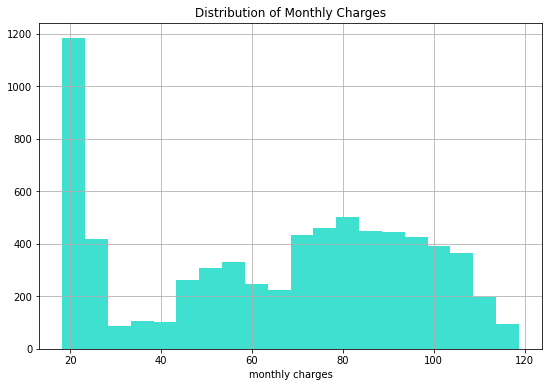

In [158]:
# Plotting histogram of monthly_charges column

df['monthly_charges'].hist(figsize=(9,6), bins=20, color='turquoise')
plt.xlabel('monthly charges')
plt.title('Distribution of Monthly Charges')
plt.show()

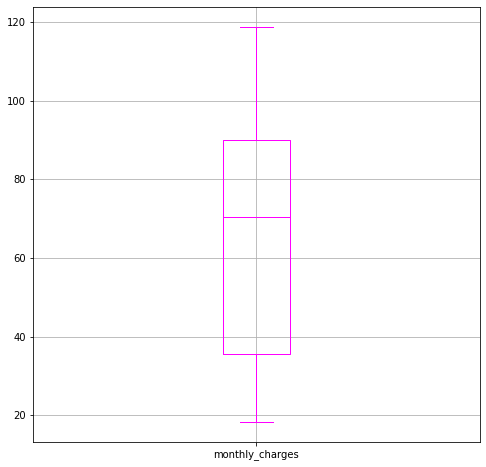

In [159]:
df.boxplot(column='monthly_charges', figsize=(8,8), color='magenta')
plt.show()

In [160]:
print('The mean monthly charge is {}'
      .format(df['monthly_charges'].mean().round(2))
     )
print('The median monthly charge is {}'
      .format(df['monthly_charges'].median().round(2))
     )

The mean monthly charge is 64.8
The median monthly charge is 70.35


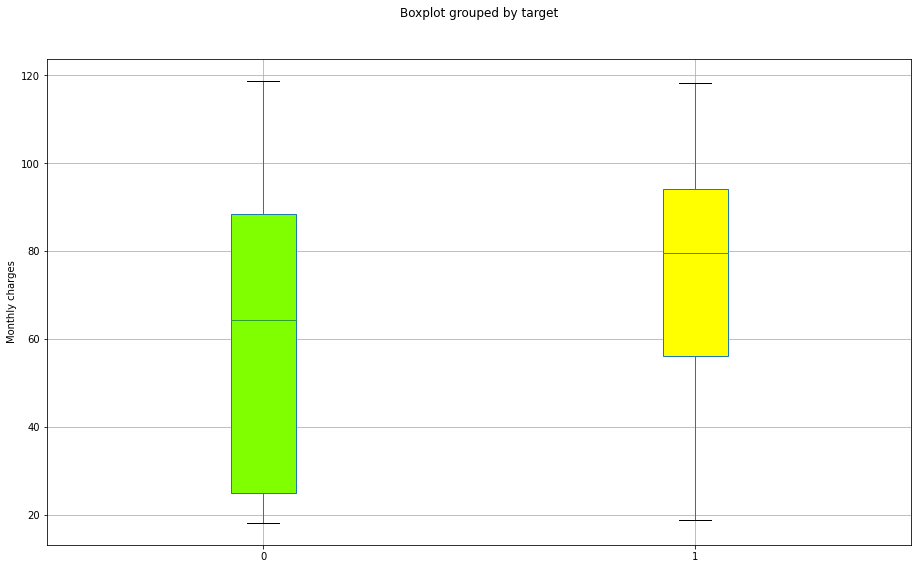

In [161]:
# Boxplot of monthly charges grouped by target

bplot = (df.boxplot(column='monthly_charges', by='target', figsize=(15,9), \
                  return_type='both', patch_artist=True)
        )

colors = ['chartreuse', 'yellow']
for row_key, (ax,row) in bplot.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])
        
plt.ylabel('Monthly charges')
plt.title(' ')
plt.show()

The distribution of monthly charges has a clear peak around 20, but the median is approximately 70, we can see on the boxplot grouped by target variable (whether a client terminated its contract or not), that the median of people ending their contract is higher at almost 80, and the interquartile range is also narrower and higher than for the customers still on their contract.

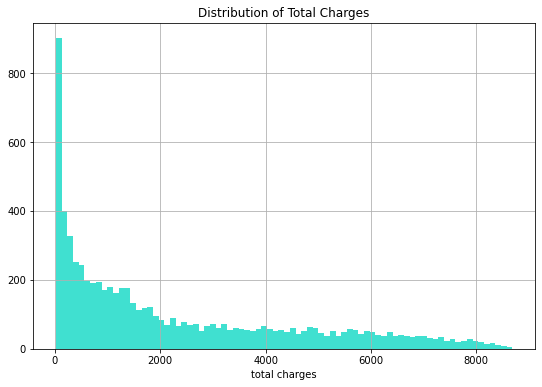

In [162]:
df['total_charges'].hist(figsize=(9,6), bins=80, color='turquoise')
plt.xlabel('total charges')
plt.title('Distribution of Total Charges')
plt.show()

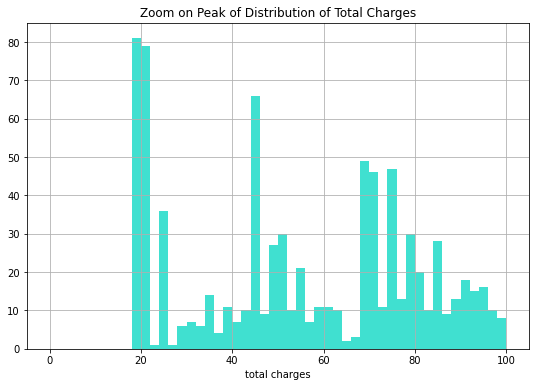

In [163]:
# Zooming in on the previous plot to see the first peak more clearly.

df['total_charges'].hist(figsize=(9,6), bins=50, color='turquoise', range=(0,100))
plt.xlabel('total charges')
plt.title('Zoom on Peak of Distribution of Total Charges')
plt.show()

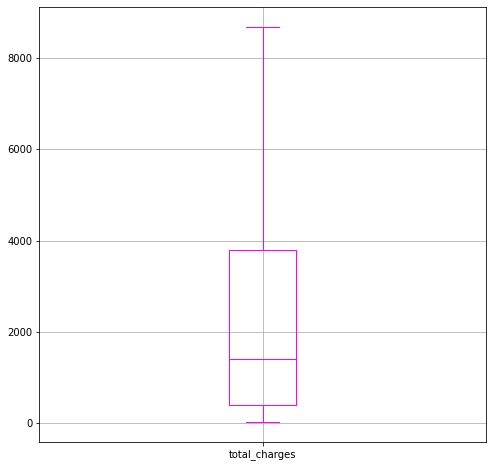

In [164]:
df.boxplot(column='total_charges', figsize=(8,8), color='magenta')
plt.show()

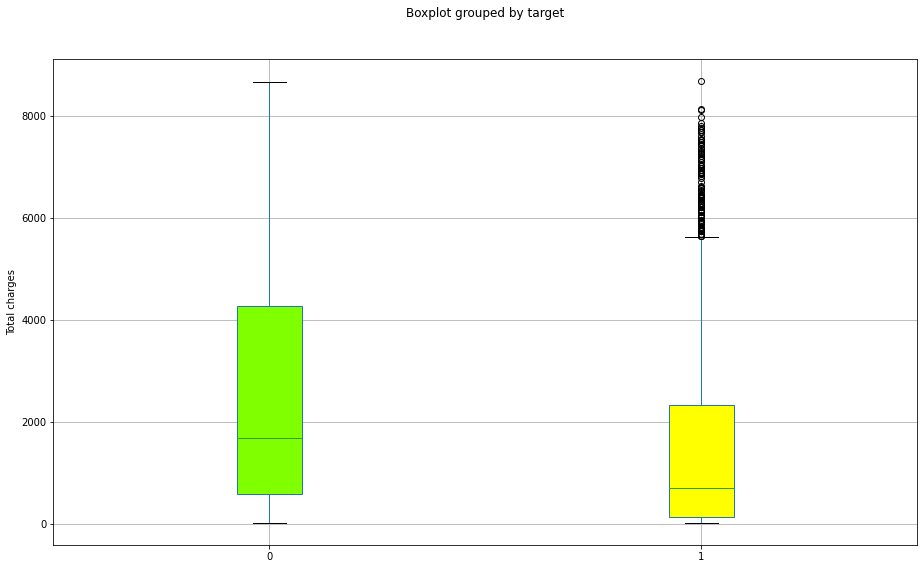

In [165]:
# Boxplot of total charges grouped by target

bplot = (df.boxplot(column='total_charges', by='target', figsize=(15,9), \
                  return_type='both', patch_artist=True)
        )

colors = ['chartreuse', 'yellow']
for row_key, (ax,row) in bplot.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])
        
plt.ylabel('Total charges')
plt.title(' ')
plt.show()

In [166]:
print('The mean total charge is {}.'
      .format(df['total_charges'].mean().round())
     )
print('The median total charge is {}.'
      .format(df['total_charges'].median().round())
     )
print('\nThe median total charge by target is: \n{}.'
      .format(df.groupby('target')['total_charges'].median().round())
     )

The mean total charge is 2283.0.
The median total charge is 1397.0.

The median total charge by target is: 
target
0    1684.0
1     704.0
Name: total_charges, dtype: float64.


The distribution of total charges is decreasing overall, with a first peak around 20, which means that a lot of customers stop their contract after just one month. The mean total charge is 2283 and median is 1397, however, the median total charge for customers leaving is lower at 704, most likely because a lot of people that left didn't keep their contract very long, which we will see next by examining the distribution of contract length.

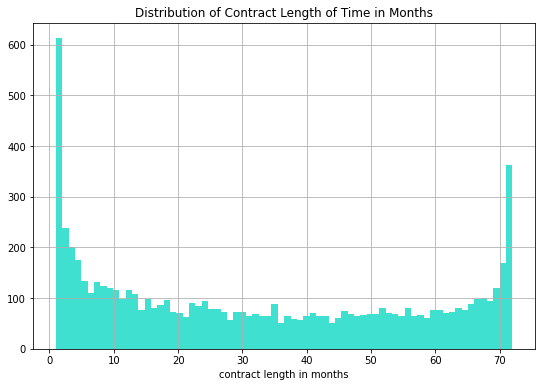

In [167]:
df['contract_length'].hist(figsize=(9,6), bins=72, color='turquoise')
plt.xlabel('contract length in months')
plt.title('Distribution of Contract Length of Time in Months')
plt.show()

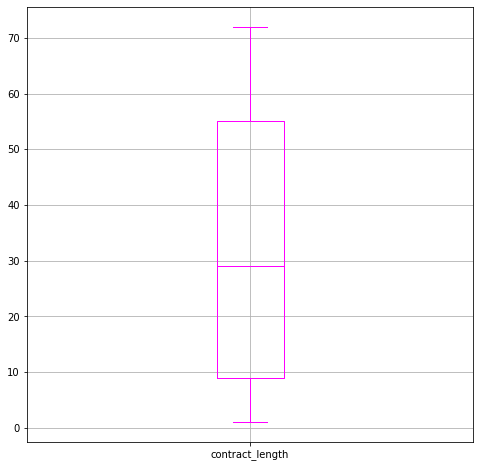

In [168]:
df.boxplot(column='contract_length', figsize=(8,8), color='magenta')
plt.show()

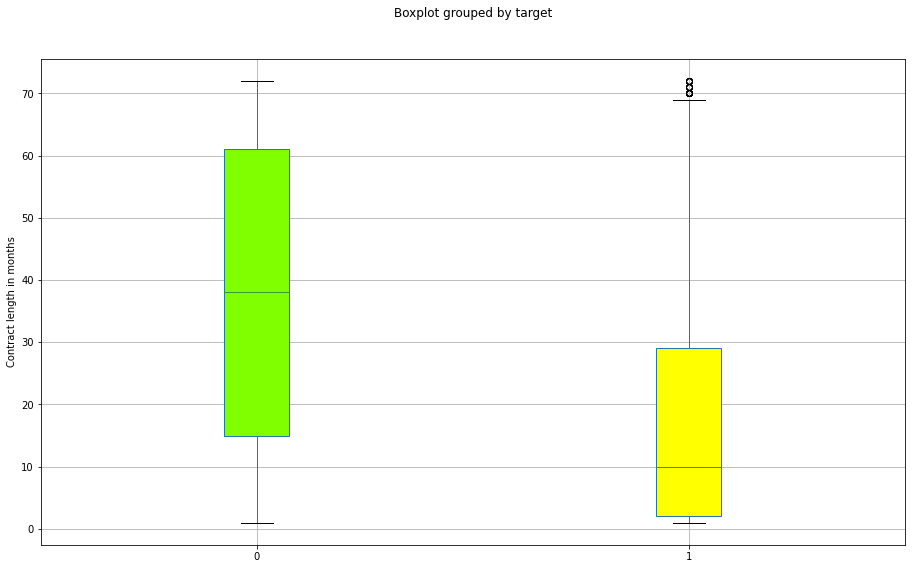

In [169]:
# Boxplot of total charges grouped by target

bplot = (df.boxplot(column='contract_length', by='target', figsize=(15,9), \
                  return_type='both', patch_artist=True)
        )

colors = ['chartreuse', 'yellow']
for row_key, (ax,row) in bplot.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])
        
plt.ylabel('Contract length in months')
plt.title(' ')
plt.show()

The distribution of contract length has two peaks, the highest one at its minimum and one at its maximum, the distribution decreases first to then become overall constant and slightly increases before the last peak. The median length of contract is just below 30 months, but the median for customers that left is lower at 10 months. The distribution for people that left has a lower and narrower interquartile range, but has more very high outliers, so even though efforts to retain customers should be concentrated on people that haven't had their contract for very long, we shouldn't neglect either the customers that have been on their contract for a long time (above 65 months seem to be a critical period too). 

### Categorical Variables

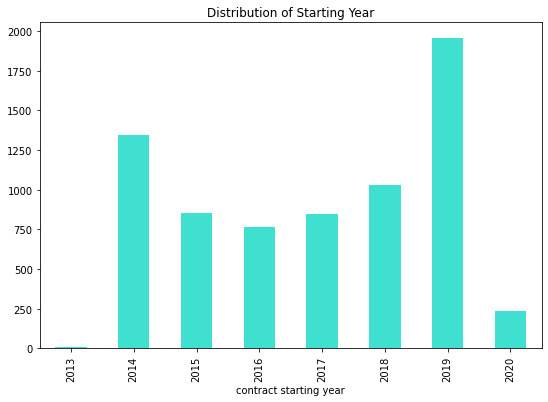

In [170]:
(df['begin_year']
 .value_counts()
 .sort_index()
 .plot(kind='bar', figsize=(9,6), color='turquoise')
)
plt.xlabel('contract starting year')
plt.title('Distribution of Starting Year')
plt.show()

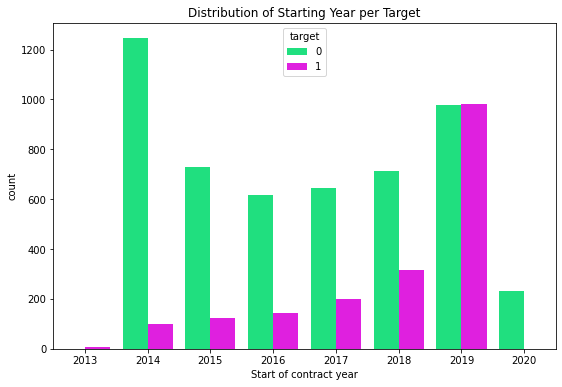

In [171]:
plt.figure(figsize=(9,6))
sns.countplot(data=df, x='begin_year', hue='target', palette={0: 'springgreen', 1: 'fuchsia'})
plt.title('Distribution of Starting Year per Target')
plt.xlabel('Start of contract year')
plt.show()

We see here that most people started their contract in 2019, followed by 2014, but the target values count for these two year is very different: most people starting in 2014 kept their contract, while about half of customers starting in 2019 ended theirs. Also the number of people leaving increased each year (despite the number of people signing up decreasing for the first couple years) slowly at first, with a sharper increase for the last year, so 2020 will be critical if the trend continues this way. 

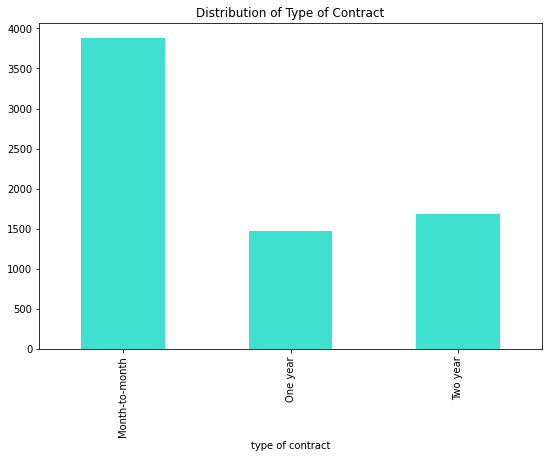

In [172]:
(df['type']
 .value_counts()
 .sort_index()
 .plot(kind='bar', figsize=(9,6), color='turquoise')
)
plt.xlabel('type of contract')
plt.title('Distribution of Type of Contract')
plt.show()

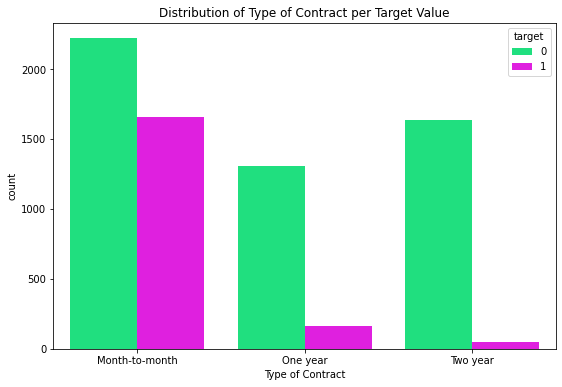

In [173]:
plt.figure(figsize=(9,6))
sns.countplot(data=df, x='type', hue='target', palette={0: 'springgreen', 1: 'fuchsia'})
plt.title('Distribution of Type of Contract per Target Value')
plt.xlabel('Type of Contract')
plt.show()

Most people favor the month-to-month option, but almost half of those choosing this option ended their contract, whereas only a few percentage of people on the one year and two year contracts ended theirs. The option that have the most customers staying is the two year contract. 

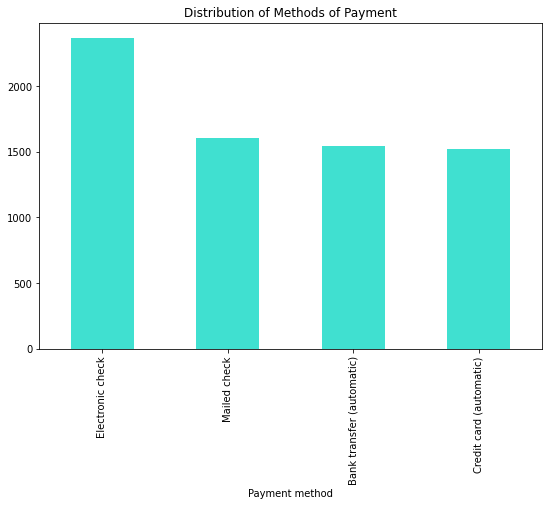

In [174]:
(df['payment_method']
 .value_counts()
 .plot(kind='bar', figsize=(9,6), color='turquoise')
)
plt.xlabel('Payment method')
plt.title('Distribution of Methods of Payment')
plt.show()

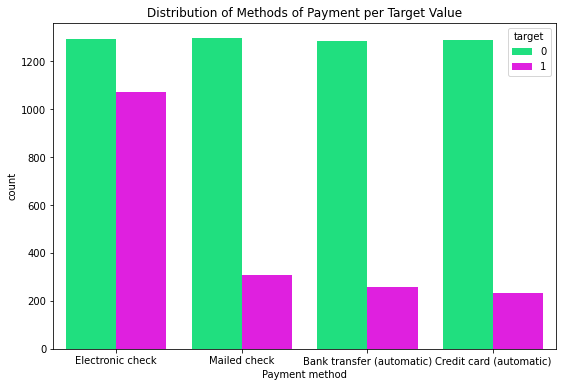

In [175]:
plt.figure(figsize=(9,6))
sns.countplot(data=df, x='payment_method', hue='target', palette={0: 'springgreen', 1: 'fuchsia'})
plt.title('Distribution of Methods of Payment per Target Value')
plt.xlabel('Payment method')
plt.show()

More people favored the electronic check but this method of payment had the biggest percentage of people leaving.

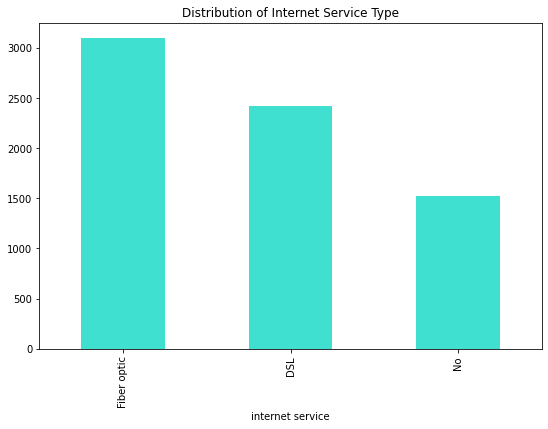

In [176]:
(df['internet_service']
 .value_counts()
 .plot(kind='bar', figsize=(9,6), color='turquoise')
)
plt.xlabel('internet service')
plt.title('Distribution of Internet Service Type')
plt.show()

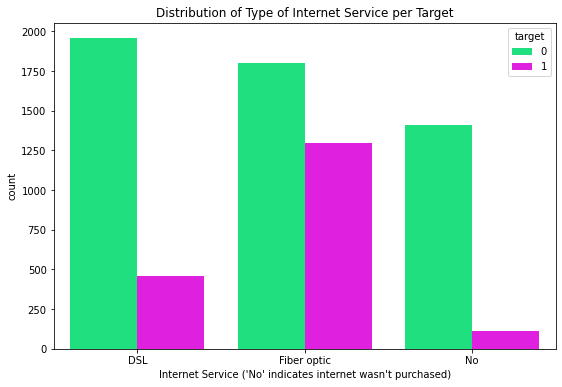

In [177]:
plt.figure(figsize=(9,6))
sns.countplot(data=df, x='internet_service', hue='target', palette={0: 'springgreen', 1: 'fuchsia'})
plt.title('Distribution of Type of Internet Service per Target')
plt.xlabel("Internet Service ('No' indicates internet wasn't purchased)")
plt.show()

Just a little below three fourth of the customers chose to have internet, of those over half of them favored fiber optic over DSL. However, a much higher percentage of people having fiber optic left over those having DSL. 

### Conclusion

We saw that people that ended their contract had higher monthly charges than people still on it, and that a big proportion of those left just after one month, or after 65 months, with a median at 10 months. The number of people leaving increased sharply last year, and while most people prefer the month-to-month option and electronic checks, but these options had the highest percentage of customers leaving, while the two-year contract, and other payment methods had the highest percentage of people staying. Fiber optic was the most popular option for internet, but also the one with the biggest percentage of people leaving.

## Model Selection

### Creating Features and Targets

In [178]:
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'begin_month',
       'begin_year', 'contract_length', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'gender', 'senior_citizen', 'partner', 'dependents',
       'multiple_lines', 'phone', 'target'],
      dtype='object')

In [179]:
# Splitting data into features and target
# Dropping contract_length to avoid data leakage as it's easy to figure out 
# whether a contract has ended with both contract_length and begin_month and 
# begin_year.

target = df['target']
features = df.drop(['customer_id', 'begin_date', 'end_date', 'contract_length', 'target'], axis=1)

In [180]:
# Splitting features and target into training, validation, and test sets

features_train, features_valid_test, target_train, target_valid_test = (
    train_test_split(features, target, test_size=0.4, random_state=12345)
)
features_valid, features_test, target_valid, target_test = (
    train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345)
)

In [181]:
features.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'begin_month', 'begin_year', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'gender', 'senior_citizen',
       'partner', 'dependents', 'multiple_lines', 'phone'],
      dtype='object')

In [182]:
# Selecting columns depending on whether feature is categorical or numerical

cat_cols = ['type', 'paperless_billing', 'payment_method', 'begin_month', \
            'begin_year', 'internet_service', \
            'online_security', 'online_backup', 'device_protection', \
            'tech_support', 'streaming_tv', 'streaming_movies', 'gender', \
            'senior_citizen', 'partner', 'dependents', 'multiple_lines', 'phone']
num_cols = ['monthly_charges', 'total_charges']

In [183]:
# Creating the transformers of columns for logistic regression, 
# scaling for numerical, ohe for categorical

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

# Creating our preprocessing pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('one-hot-encoder', categorical_preprocessor, cat_cols), 
        ('standard_scaler', numerical_preprocessor, num_cols)
    ]
)

In [184]:
# Transforming our features sets with the preprocessor created above

features_train_ohe = preprocessor.fit_transform(features_train)
features_valid_ohe = preprocessor.transform(features_valid)
features_test_ohe = preprocessor.transform(features_test)

In [185]:
# Creating the preprocessor for tree based algorithms

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(), cat_cols), 
        #('standard_scaler', numerical_preprocessor, num_cols)
    ]
)

In [186]:
# transforming features with the preprocessor for tree based algorithms

features_train_ord = preprocessor.fit_transform(features_train)
features_valid_ord = preprocessor.transform(features_valid)
features_test_ord = preprocessor.transform(features_test)

Features and target were created, dropping non-essential columns for predictions, then split into training, validation, and test sets. Those were then preprocessed in two different ways, with One-Hot-Encoding and Scaling that will be used for logistic regression, and with OrdinalEncoder for tree-based algorithms. All categorical features had only a small number of categories so we didn't need to drop additional variables before using OHE. 

### Evaluation Function for our Models

In [187]:
def print_model_eval(target, features, model):
    predictions = model.predict(features)
    probs = model.predict_proba(features)
    print('Accuracy score : ' + str((accuracy_score(target, predictions)*100).round(2)) + '%')
    print('ROC AUC score : ' + str((roc_auc_score(target, probs[:,1])*100).round(2)) + '%')

### Baseline Model

In [188]:
# Creating a dummy classifier

model_dummy = DummyClassifier(random_state=12345, strategy='constant', constant=1)
model_dummy.fit(features_train, target_train)

DummyClassifier(constant=1, random_state=12345, strategy='constant')

In [189]:
print_model_eval(target_valid, features_valid, model_dummy)

Accuracy score : 26.17%
ROC AUC score : 50.0%


### Logistic Regression 

#### With Balanced Class Weights

In [190]:
model_lr = LogisticRegression(random_state=12345, class_weight='balanced')
model_lr.fit(features_train_ohe, target_train) 

LogisticRegression(class_weight='balanced', random_state=12345)

In [191]:
print_model_eval(target_valid, features_valid_ohe, model_lr)

Accuracy score : 75.18%
ROC AUC score : 85.76%


We already get a high enough ROC AUC score at 0.86, but let's try other models to see how they compare and see if we can do even better.

#### With Oversampling

Instead of adjusting class weights, we are now going to over-sample using SMOTE (Synthetic Minority Oversampling Technique) from the imbalanced-learn Python library.

In [192]:
# transforming the dataset using SMOTE

oversample = SMOTE()
features_train_ohe_smote, target_train_smote = oversample.fit_resample(
    features_train_ohe, target_train
)

In [193]:
model_lr_smote = LogisticRegression(random_state=12345)
model_lr_smote.fit(features_train_ohe_smote, target_train_smote)
#predicted_valid = model_lr_smote.predict(features_valid_ohe)

In [194]:
# Evaluating this upsampled logistic regression model

print_model_eval(target_valid, features_valid_ohe, model_lr_smote)

Accuracy score : 76.17%
ROC AUC score : 85.86%


We see a very small improvement of all scores of less than one percent by using oversampling to balance class weights instead of using the class weight parameter. Let's see how combining over and undersampling using the class SMOTETomek would compare with this:

#### With Oversampling and Undersampling

In [195]:
smote_tomek = SMOTETomek(random_state=0)
features_train_ohe_tomek, target_train_ohe_tomek = smote_tomek.fit_resample(features_train_ohe, target_train)

In [196]:
model_lr_tomek = LogisticRegression(random_state=12345)
model_lr_tomek.fit(features_train_ohe_tomek, target_train_ohe_tomek)
#predicted_valid = model_lr_tomek.predict(features_valid_ohe)

In [197]:
print_model_eval(target_valid, features_valid_ohe, model_lr_tomek)

Accuracy score : 76.1%
ROC AUC score : 85.75%


Results are very similar with what we already saw, so let's try other models now:

### Random forest

####  With Class Weight and Hyperparameter Tuning

In [198]:
parameters = {
    'max_depth': [5,7,12],
    'n_estimators': [10,25,100],
    'min_samples_split':[2,5,7]
}

In [199]:
model_rf = RandomForestClassifier(random_state=12345, class_weight='balanced')
clf = GridSearchCV(model_rf, parameters, verbose=2)

clf.fit(features_train_ord, target_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END .max_depth=5, min_samples_split=2, n_e

[CV] END max_depth=12, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=12, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=12, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=12, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=25; total time=   0.1s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=25; total time=   0.1s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=25; total time=   0.1s
[CV] END .max_depth=12, min_

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345),
             param_grid={'max_depth': [5, 7, 12],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [10, 25, 100]},
             verbose=2)

In [200]:
clf.best_params_

{'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 100}

In [201]:
model_rf = clf.best_estimator_

In [202]:
print_model_eval(target_valid, features_valid_ord, model_rf)

Accuracy score : 78.02%
ROC AUC score : 85.29%


Accuracy is better than logistic regression but ROC AUC is very similar. Let's see other methods of adjusting class weights to see if that might improve the score for random forest.

#### With Oversampling and Hyperparameter Tuning

Let's see if we can improve the scores by using SMOTE instead of class weights to fix class imbalances:

In [203]:
oversample = SMOTE()
features_train_ord_smote, target_train_ord_smote = oversample.fit_resample(features_train_ord, target_train)

In [204]:
model_rf2 = RandomForestClassifier(random_state=12345)
clf = GridSearchCV(model_rf2, parameters, verbose=2)

clf.fit(features_train_ord_smote, target_train_ord_smote)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=5, min_samples_split=2, n_e

[CV] END max_depth=12, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=12, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=12, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=12, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=25; total time=   0.1s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=25; total time=   0.1s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=25; total time=   0.1s
[CV] END .max_depth=12, min_

GridSearchCV(estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': [5, 7, 12],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [10, 25, 100]},
             verbose=2)

In [205]:
clf.best_params_

{'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 100}

In [206]:
model_rf2 = clf.best_estimator_

In [207]:
print_model_eval(target_valid, features_valid_ord, model_rf2)

Accuracy score : 78.95%
ROC AUC score : 84.91%


Accuracy is even better but roc auc got very slightly worse.

#### With Oversampling and Undersampling and Hyperparameter Tuning

In [208]:
smote_tomek = SMOTETomek(random_state=0)
features_train_ord_tomek, target_train_ord_tomek = smote_tomek.fit_resample(features_train_ord, target_train)

In [209]:
model_rf3 = RandomForestClassifier(random_state=12345)
clf = GridSearchCV(model_rf3, parameters, verbose=2)

clf.fit(features_train_ord_tomek, target_train_ord_tomek)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=5, min_samples_split=2, n_e

[CV] END max_depth=12, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=12, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=12, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=12, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=25; total time=   0.1s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=25; total time=   0.1s
[CV] END .max_depth=12, min_samples_split=5, n_estimators=25; total time=   0.1s
[CV] END .max_depth=12, min_

GridSearchCV(estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': [5, 7, 12],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [10, 25, 100]},
             verbose=2)

In [210]:
clf.best_params_

{'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 100}

In [211]:
model_rf3 = clf.best_estimator_

In [212]:
print_model_eval(target_valid, features_valid_ord, model_rf3)

Accuracy score : 78.73%
ROC AUC score : 85.03%


We still get very similar results than the other two methods, so let's move on to another model to see if we can do better than the score for logistic regression.

### Catboostclassifier with Hyperparameter Tuning

In [270]:
parameters = {
    'iterations': [100, 200],
    'auto_class_weights': ['Balanced', 'SqrtBalanced', 'None'],
    'max_depth' : [6,8]
}

In [271]:
model_cb = CatBoostClassifier(random_state=12345, cat_features=cat_cols)
clf = GridSearchCV(model_cb, parameters, verbose=2)
clf.fit(features_train, target_train, eval_set=(features_valid, target_valid))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Learning rate set to 0.116518
0:	learn: 0.6432294	test: 0.6423750	best: 0.6423750 (0)	total: 5.78ms	remaining: 572ms
1:	learn: 0.6102837	test: 0.6095200	best: 0.6095200 (1)	total: 11ms	remaining: 539ms
2:	learn: 0.5793768	test: 0.5786042	best: 0.5786042 (2)	total: 15.7ms	remaining: 508ms
3:	learn: 0.5611302	test: 0.5612258	best: 0.5612258 (3)	total: 20.5ms	remaining: 491ms
4:	learn: 0.5457398	test: 0.5473337	best: 0.5473337 (4)	total: 25.4ms	remaining: 483ms
5:	learn: 0.5342393	test: 0.5368183	best: 0.5368183 (5)	total: 30.1ms	remaining: 471ms
6:	learn: 0.5228192	test: 0.5256788	best: 0.5256788 (6)	total: 35ms	remaining: 465ms
7:	learn: 0.5011172	test: 0.5043347	best: 0.5043347 (7)	total: 39.8ms	remaining: 458ms
8:	learn: 0.4879192	test: 0.4906154	best: 0.4906154 (8)	total: 44.5ms	remaining: 450ms
9:	learn: 0.4804158	test: 0.4826222	best: 0.4826222 (9)	total: 48.5ms	remaining: 437ms
10:	learn: 0.4739225	test: 0.4764544	best: 

[CV] END auto_class_weights=Balanced, iterations=100, max_depth=6; total time=   1.4s
Learning rate set to 0.116518
0:	learn: 0.6459388	test: 0.6436868	best: 0.6436868 (0)	total: 10.1ms	remaining: 1s
1:	learn: 0.6149169	test: 0.6108796	best: 0.6108796 (1)	total: 18.8ms	remaining: 923ms
2:	learn: 0.5851643	test: 0.5815323	best: 0.5815323 (2)	total: 27.4ms	remaining: 884ms
3:	learn: 0.5688125	test: 0.5646667	best: 0.5646667 (3)	total: 35.1ms	remaining: 841ms
4:	learn: 0.5570716	test: 0.5535836	best: 0.5535836 (4)	total: 38.9ms	remaining: 739ms
5:	learn: 0.5474532	test: 0.5432166	best: 0.5432166 (5)	total: 42.4ms	remaining: 664ms
6:	learn: 0.5339266	test: 0.5309705	best: 0.5309705 (6)	total: 47.3ms	remaining: 628ms
7:	learn: 0.5156634	test: 0.5158617	best: 0.5158617 (7)	total: 52.2ms	remaining: 601ms
8:	learn: 0.4998372	test: 0.4993412	best: 0.4993412 (8)	total: 57.1ms	remaining: 577ms
9:	learn: 0.4878714	test: 0.4879040	best: 0.4879040 (9)	total: 61.9ms	remaining: 557ms
10:	learn: 0.4820

[CV] END auto_class_weights=Balanced, iterations=100, max_depth=6; total time=   1.3s
Learning rate set to 0.116518
0:	learn: 0.6459136	test: 0.6447666	best: 0.6447666 (0)	total: 5.69ms	remaining: 564ms
1:	learn: 0.6146976	test: 0.6129592	best: 0.6129592 (1)	total: 10.8ms	remaining: 531ms
2:	learn: 0.5869615	test: 0.5858105	best: 0.5858105 (2)	total: 15.5ms	remaining: 502ms
3:	learn: 0.5664661	test: 0.5660974	best: 0.5660974 (3)	total: 20.5ms	remaining: 492ms
4:	learn: 0.5522490	test: 0.5534570	best: 0.5534570 (4)	total: 25.5ms	remaining: 484ms
5:	learn: 0.5413941	test: 0.5426032	best: 0.5426032 (5)	total: 30.4ms	remaining: 476ms
6:	learn: 0.5304972	test: 0.5321536	best: 0.5321536 (6)	total: 35.3ms	remaining: 469ms
7:	learn: 0.5117517	test: 0.5121834	best: 0.5121834 (7)	total: 40.1ms	remaining: 461ms
8:	learn: 0.4951780	test: 0.4962173	best: 0.4962173 (8)	total: 45ms	remaining: 455ms
9:	learn: 0.4845739	test: 0.4870242	best: 0.4870242 (9)	total: 49.6ms	remaining: 446ms
10:	learn: 0.475

[CV] END auto_class_weights=Balanced, iterations=100, max_depth=6; total time=   1.3s
Learning rate set to 0.116518
0:	learn: 0.6458211	test: 0.6435532	best: 0.6435532 (0)	total: 7.56ms	remaining: 749ms
1:	learn: 0.6128267	test: 0.6099134	best: 0.6099134 (1)	total: 13.2ms	remaining: 647ms
2:	learn: 0.5855632	test: 0.5823987	best: 0.5823987 (2)	total: 18.8ms	remaining: 609ms
3:	learn: 0.5669362	test: 0.5631626	best: 0.5631626 (3)	total: 24.2ms	remaining: 582ms
4:	learn: 0.5509729	test: 0.5476688	best: 0.5476688 (4)	total: 29.8ms	remaining: 565ms
5:	learn: 0.5401604	test: 0.5369010	best: 0.5369010 (5)	total: 35.2ms	remaining: 552ms
6:	learn: 0.5300164	test: 0.5268471	best: 0.5268471 (6)	total: 41.8ms	remaining: 556ms
7:	learn: 0.5115288	test: 0.5074555	best: 0.5074555 (7)	total: 49.3ms	remaining: 567ms
8:	learn: 0.4941939	test: 0.4910909	best: 0.4910909 (8)	total: 55.3ms	remaining: 559ms
9:	learn: 0.4838067	test: 0.4805573	best: 0.4805573 (9)	total: 61.1ms	remaining: 550ms
10:	learn: 0.4

[CV] END auto_class_weights=Balanced, iterations=100, max_depth=6; total time=   1.5s
Learning rate set to 0.116526
0:	learn: 0.6579287	test: 0.6563075	best: 0.6563075 (0)	total: 4.26ms	remaining: 422ms
1:	learn: 0.6330704	test: 0.6313680	best: 0.6313680 (1)	total: 8.47ms	remaining: 415ms
2:	learn: 0.6131166	test: 0.6097499	best: 0.6097499 (2)	total: 11.6ms	remaining: 377ms
3:	learn: 0.5855022	test: 0.5810267	best: 0.5810267 (3)	total: 16.7ms	remaining: 402ms
4:	learn: 0.5661797	test: 0.5612121	best: 0.5612121 (4)	total: 21.9ms	remaining: 416ms
5:	learn: 0.5560162	test: 0.5506175	best: 0.5506175 (5)	total: 24.6ms	remaining: 385ms
6:	learn: 0.5425265	test: 0.5379518	best: 0.5379518 (6)	total: 29.3ms	remaining: 389ms
7:	learn: 0.5229123	test: 0.5175263	best: 0.5175263 (7)	total: 34ms	remaining: 391ms
8:	learn: 0.5051361	test: 0.5010221	best: 0.5010221 (8)	total: 38.8ms	remaining: 392ms
9:	learn: 0.4919229	test: 0.4871166	best: 0.4871166 (9)	total: 43.4ms	remaining: 390ms
10:	learn: 0.479

[CV] END auto_class_weights=Balanced, iterations=100, max_depth=6; total time=   1.3s
Learning rate set to 0.116518
0:	learn: 0.6389938	test: 0.6407712	best: 0.6407712 (0)	total: 9.82ms	remaining: 972ms
1:	learn: 0.5993121	test: 0.6016340	best: 0.6016340 (1)	total: 18.9ms	remaining: 929ms
2:	learn: 0.5789398	test: 0.5802536	best: 0.5802536 (2)	total: 21.7ms	remaining: 702ms
3:	learn: 0.5569299	test: 0.5586677	best: 0.5586677 (3)	total: 26.8ms	remaining: 642ms
4:	learn: 0.5432874	test: 0.5455192	best: 0.5455192 (4)	total: 30.9ms	remaining: 586ms
5:	learn: 0.5236746	test: 0.5308780	best: 0.5308780 (5)	total: 39.4ms	remaining: 618ms
6:	learn: 0.5075893	test: 0.5134684	best: 0.5134684 (6)	total: 48.3ms	remaining: 642ms
7:	learn: 0.4964624	test: 0.5022408	best: 0.5022408 (7)	total: 56.7ms	remaining: 652ms
8:	learn: 0.4819835	test: 0.4868562	best: 0.4868562 (8)	total: 62.6ms	remaining: 633ms
9:	learn: 0.4697058	test: 0.4798656	best: 0.4798656 (9)	total: 71.7ms	remaining: 645ms
10:	learn: 0.4

98:	learn: 0.2703014	test: 0.4099592	best: 0.4085422 (96)	total: 764ms	remaining: 7.72ms
99:	learn: 0.2680900	test: 0.4102481	best: 0.4085422 (96)	total: 773ms	remaining: 0us

bestTest = 0.4085422389
bestIteration = 96

Shrink model to first 97 iterations.
[CV] END auto_class_weights=Balanced, iterations=100, max_depth=8; total time=   1.5s
Learning rate set to 0.116518
0:	learn: 0.6421127	test: 0.6434428	best: 0.6434428 (0)	total: 10.4ms	remaining: 1.03s
1:	learn: 0.6018265	test: 0.6031418	best: 0.6031418 (1)	total: 21ms	remaining: 1.03s
2:	learn: 0.5827855	test: 0.5822753	best: 0.5822753 (2)	total: 23.9ms	remaining: 772ms
3:	learn: 0.5565109	test: 0.5587956	best: 0.5587956 (3)	total: 34.1ms	remaining: 817ms
4:	learn: 0.5442320	test: 0.5464437	best: 0.5464437 (4)	total: 37.9ms	remaining: 720ms
5:	learn: 0.5308827	test: 0.5342498	best: 0.5342498 (5)	total: 48ms	remaining: 751ms
6:	learn: 0.5227665	test: 0.5267925	best: 0.5267925 (6)	total: 51.9ms	remaining: 690ms
7:	learn: 0.5098659	te

92:	learn: 0.2664728	test: 0.4032696	best: 0.4030281 (90)	total: 762ms	remaining: 57.4ms
93:	learn: 0.2642195	test: 0.4019021	best: 0.4019021 (93)	total: 771ms	remaining: 49.2ms
94:	learn: 0.2628589	test: 0.4028355	best: 0.4019021 (93)	total: 781ms	remaining: 41.1ms
95:	learn: 0.2587565	test: 0.4000829	best: 0.4000829 (95)	total: 790ms	remaining: 32.9ms
96:	learn: 0.2568122	test: 0.4001114	best: 0.4000829 (95)	total: 799ms	remaining: 24.7ms
97:	learn: 0.2548502	test: 0.4015317	best: 0.4000829 (95)	total: 809ms	remaining: 16.5ms
98:	learn: 0.2530874	test: 0.4015734	best: 0.4000829 (95)	total: 818ms	remaining: 8.27ms
99:	learn: 0.2508083	test: 0.4006980	best: 0.4000829 (95)	total: 829ms	remaining: 0us

bestTest = 0.4000828877
bestIteration = 95

Shrink model to first 96 iterations.
[CV] END auto_class_weights=Balanced, iterations=100, max_depth=8; total time=   1.7s
Learning rate set to 0.116518
0:	learn: 0.6410103	test: 0.6436255	best: 0.6436255 (0)	total: 9.63ms	remaining: 953ms
1:	lea

96:	learn: 0.2545286	test: 0.4179747	best: 0.4179058 (95)	total: 765ms	remaining: 23.7ms
97:	learn: 0.2531323	test: 0.4163938	best: 0.4163938 (97)	total: 774ms	remaining: 15.8ms
98:	learn: 0.2492602	test: 0.4183235	best: 0.4163938 (97)	total: 784ms	remaining: 7.91ms
99:	learn: 0.2463872	test: 0.4189013	best: 0.4163938 (97)	total: 793ms	remaining: 0us

bestTest = 0.4163937996
bestIteration = 97

Shrink model to first 98 iterations.
[CV] END auto_class_weights=Balanced, iterations=100, max_depth=8; total time=   1.6s
Learning rate set to 0.116518
0:	learn: 0.6434697	test: 0.6438756	best: 0.6438756 (0)	total: 9.81ms	remaining: 971ms
1:	learn: 0.6065492	test: 0.6042513	best: 0.6042513 (1)	total: 19.1ms	remaining: 936ms
2:	learn: 0.5884607	test: 0.5831752	best: 0.5831752 (2)	total: 21.8ms	remaining: 705ms
3:	learn: 0.5630943	test: 0.5609634	best: 0.5609634 (3)	total: 30.6ms	remaining: 735ms
4:	learn: 0.5506035	test: 0.5484693	best: 0.5484693 (4)	total: 34ms	remaining: 646ms
5:	learn: 0.5324

93:	learn: 0.2633241	test: 0.3997644	best: 0.3982327 (85)	total: 773ms	remaining: 49.4ms
94:	learn: 0.2607887	test: 0.3984732	best: 0.3982327 (85)	total: 785ms	remaining: 41.3ms
95:	learn: 0.2589656	test: 0.3982172	best: 0.3982172 (95)	total: 794ms	remaining: 33.1ms
96:	learn: 0.2582796	test: 0.3983423	best: 0.3982172 (95)	total: 803ms	remaining: 24.8ms
97:	learn: 0.2565876	test: 0.3984312	best: 0.3982172 (95)	total: 812ms	remaining: 16.6ms
98:	learn: 0.2551301	test: 0.3994363	best: 0.3982172 (95)	total: 821ms	remaining: 8.29ms
99:	learn: 0.2536431	test: 0.3991621	best: 0.3982172 (95)	total: 830ms	remaining: 0us

bestTest = 0.3982172006
bestIteration = 95

Shrink model to first 96 iterations.
[CV] END auto_class_weights=Balanced, iterations=100, max_depth=8; total time=   1.7s
Learning rate set to 0.116526
0:	learn: 0.6579287	test: 0.6563075	best: 0.6563075 (0)	total: 4.14ms	remaining: 410ms
1:	learn: 0.6330704	test: 0.6313680	best: 0.6313680 (1)	total: 8.46ms	remaining: 415ms
2:	learn

94:	learn: 0.2721849	test: 0.4054409	best: 0.4046049 (90)	total: 743ms	remaining: 39.1ms
95:	learn: 0.2688743	test: 0.4025356	best: 0.4025356 (95)	total: 752ms	remaining: 31.3ms
96:	learn: 0.2675328	test: 0.4026642	best: 0.4025356 (95)	total: 761ms	remaining: 23.5ms
97:	learn: 0.2646580	test: 0.4029485	best: 0.4025356 (95)	total: 770ms	remaining: 15.7ms
98:	learn: 0.2636490	test: 0.4024407	best: 0.4024407 (98)	total: 779ms	remaining: 7.87ms
99:	learn: 0.2622854	test: 0.4033927	best: 0.4024407 (98)	total: 788ms	remaining: 0us

bestTest = 0.4024407026
bestIteration = 98

Shrink model to first 99 iterations.
[CV] END auto_class_weights=Balanced, iterations=100, max_depth=8; total time=   1.7s
Learning rate set to 0.086188
0:	learn: 0.6556573	test: 0.6571131	best: 0.6571131 (0)	total: 10.1ms	remaining: 2.01s
1:	learn: 0.6236570	test: 0.6250148	best: 0.6250148 (1)	total: 18.6ms	remaining: 1.84s
2:	learn: 0.6055020	test: 0.6058341	best: 0.6058341 (2)	total: 23.3ms	remaining: 1.53s
3:	learn: 

89:	learn: 0.3792033	test: 0.4220084	best: 0.4220084 (89)	total: 768ms	remaining: 939ms
90:	learn: 0.3788632	test: 0.4220031	best: 0.4220031 (90)	total: 776ms	remaining: 929ms
91:	learn: 0.3788632	test: 0.4220031	best: 0.4220031 (90)	total: 779ms	remaining: 914ms
92:	learn: 0.3782691	test: 0.4219184	best: 0.4219184 (92)	total: 786ms	remaining: 905ms
93:	learn: 0.3765072	test: 0.4201665	best: 0.4201665 (93)	total: 796ms	remaining: 898ms
94:	learn: 0.3762057	test: 0.4201841	best: 0.4201665 (93)	total: 806ms	remaining: 891ms
95:	learn: 0.3754274	test: 0.4201522	best: 0.4201522 (95)	total: 815ms	remaining: 883ms
96:	learn: 0.3742328	test: 0.4191086	best: 0.4191086 (96)	total: 824ms	remaining: 875ms
97:	learn: 0.3728552	test: 0.4196523	best: 0.4191086 (96)	total: 833ms	remaining: 867ms
98:	learn: 0.3715242	test: 0.4194897	best: 0.4191086 (96)	total: 842ms	remaining: 859ms
99:	learn: 0.3706795	test: 0.4187224	best: 0.4187224 (99)	total: 851ms	remaining: 851ms
100:	learn: 0.3685583	test: 0.41

192:	learn: 0.2759476	test: 0.3844104	best: 0.3841246 (190)	total: 1.72s	remaining: 62.5ms
193:	learn: 0.2755898	test: 0.3844312	best: 0.3841246 (190)	total: 1.73s	remaining: 53.6ms
194:	learn: 0.2750343	test: 0.3842294	best: 0.3841246 (190)	total: 1.74s	remaining: 44.6ms
195:	learn: 0.2738493	test: 0.3845765	best: 0.3841246 (190)	total: 1.75s	remaining: 35.7ms
196:	learn: 0.2733782	test: 0.3844749	best: 0.3841246 (190)	total: 1.76s	remaining: 26.8ms
197:	learn: 0.2726375	test: 0.3848060	best: 0.3841246 (190)	total: 1.76s	remaining: 17.8ms
198:	learn: 0.2713233	test: 0.3835491	best: 0.3835491 (198)	total: 1.77s	remaining: 8.91ms
199:	learn: 0.2702199	test: 0.3832689	best: 0.3832689 (199)	total: 1.78s	remaining: 0us

bestTest = 0.3832688813
bestIteration = 199

[CV] END auto_class_weights=Balanced, iterations=200, max_depth=6; total time=   2.7s
Learning rate set to 0.086188
0:	learn: 0.6584415	test: 0.6584692	best: 0.6584692 (0)	total: 10.4ms	remaining: 2.07s
1:	learn: 0.6296395	test: 

97:	learn: 0.3703949	test: 0.4128576	best: 0.4128576 (97)	total: 765ms	remaining: 796ms
98:	learn: 0.3693138	test: 0.4125367	best: 0.4125367 (98)	total: 774ms	remaining: 789ms
99:	learn: 0.3689298	test: 0.4123367	best: 0.4123367 (99)	total: 784ms	remaining: 784ms
100:	learn: 0.3685895	test: 0.4120971	best: 0.4120971 (100)	total: 792ms	remaining: 777ms
101:	learn: 0.3670598	test: 0.4127099	best: 0.4120971 (100)	total: 800ms	remaining: 768ms
102:	learn: 0.3630224	test: 0.4086348	best: 0.4086348 (102)	total: 809ms	remaining: 762ms
103:	learn: 0.3624704	test: 0.4087371	best: 0.4086348 (102)	total: 817ms	remaining: 754ms
104:	learn: 0.3607638	test: 0.4091410	best: 0.4086348 (102)	total: 826ms	remaining: 747ms
105:	learn: 0.3606741	test: 0.4090982	best: 0.4086348 (102)	total: 834ms	remaining: 739ms
106:	learn: 0.3602236	test: 0.4089698	best: 0.4086348 (102)	total: 843ms	remaining: 732ms
107:	learn: 0.3587181	test: 0.4075911	best: 0.4075911 (107)	total: 857ms	remaining: 730ms
108:	learn: 0.35

198:	learn: 0.2666563	test: 0.3771252	best: 0.3771252 (198)	total: 1.71s	remaining: 8.59ms
199:	learn: 0.2657560	test: 0.3770702	best: 0.3770702 (199)	total: 1.72s	remaining: 0us

bestTest = 0.3770701806
bestIteration = 199

[CV] END auto_class_weights=Balanced, iterations=200, max_depth=6; total time=   2.9s
Learning rate set to 0.086188
0:	learn: 0.6628735	test: 0.6623485	best: 0.6623485 (0)	total: 7.29ms	remaining: 1.45s
1:	learn: 0.6367051	test: 0.6360509	best: 0.6360509 (1)	total: 14.6ms	remaining: 1.45s
2:	learn: 0.6114932	test: 0.6102325	best: 0.6102325 (2)	total: 23.5ms	remaining: 1.54s
3:	learn: 0.5957938	test: 0.5939584	best: 0.5939584 (3)	total: 30.4ms	remaining: 1.49s
4:	learn: 0.5730924	test: 0.5709422	best: 0.5709422 (4)	total: 39.4ms	remaining: 1.54s
5:	learn: 0.5555218	test: 0.5537674	best: 0.5537674 (5)	total: 48.2ms	remaining: 1.56s
6:	learn: 0.5423943	test: 0.5400060	best: 0.5400060 (6)	total: 55.5ms	remaining: 1.53s
7:	learn: 0.5332482	test: 0.5307403	best: 0.530740

96:	learn: 0.3703741	test: 0.4195372	best: 0.4195372 (96)	total: 750ms	remaining: 797ms
97:	learn: 0.3694177	test: 0.4187116	best: 0.4187116 (97)	total: 761ms	remaining: 792ms
98:	learn: 0.3684847	test: 0.4187515	best: 0.4187116 (97)	total: 769ms	remaining: 784ms
99:	learn: 0.3661609	test: 0.4173397	best: 0.4173397 (99)	total: 777ms	remaining: 777ms
100:	learn: 0.3651282	test: 0.4173495	best: 0.4173397 (99)	total: 786ms	remaining: 770ms
101:	learn: 0.3639895	test: 0.4172536	best: 0.4172536 (101)	total: 795ms	remaining: 763ms
102:	learn: 0.3633967	test: 0.4172764	best: 0.4172536 (101)	total: 804ms	remaining: 757ms
103:	learn: 0.3622554	test: 0.4173936	best: 0.4172536 (101)	total: 813ms	remaining: 751ms
104:	learn: 0.3607215	test: 0.4179715	best: 0.4172536 (101)	total: 822ms	remaining: 744ms
105:	learn: 0.3587334	test: 0.4164029	best: 0.4164029 (105)	total: 831ms	remaining: 737ms
106:	learn: 0.3560996	test: 0.4131056	best: 0.4131056 (106)	total: 840ms	remaining: 730ms
107:	learn: 0.35446

194:	learn: 0.2634368	test: 0.3890968	best: 0.3887717 (191)	total: 1.69s	remaining: 43.4ms
195:	learn: 0.2629211	test: 0.3890643	best: 0.3887717 (191)	total: 1.7s	remaining: 34.7ms
196:	learn: 0.2621999	test: 0.3886656	best: 0.3886656 (196)	total: 1.71s	remaining: 26.1ms
197:	learn: 0.2617128	test: 0.3884285	best: 0.3884285 (197)	total: 1.72s	remaining: 17.4ms
198:	learn: 0.2610080	test: 0.3884359	best: 0.3884285 (197)	total: 1.73s	remaining: 8.69ms
199:	learn: 0.2607032	test: 0.3883708	best: 0.3883708 (199)	total: 1.74s	remaining: 0us

bestTest = 0.3883707802
bestIteration = 199

[CV] END auto_class_weights=Balanced, iterations=200, max_depth=6; total time=   2.6s
Learning rate set to 0.086188
0:	learn: 0.6632673	test: 0.6624278	best: 0.6624278 (0)	total: 7.22ms	remaining: 1.44s
1:	learn: 0.6348521	test: 0.6336125	best: 0.6336125 (1)	total: 14.5ms	remaining: 1.44s
2:	learn: 0.6114894	test: 0.6093820	best: 0.6093820 (2)	total: 21.6ms	remaining: 1.42s
3:	learn: 0.5909117	test: 0.5883194

93:	learn: 0.3824366	test: 0.4195094	best: 0.4195094 (93)	total: 742ms	remaining: 836ms
94:	learn: 0.3811725	test: 0.4183093	best: 0.4183093 (94)	total: 750ms	remaining: 829ms
95:	learn: 0.3799105	test: 0.4175430	best: 0.4175430 (95)	total: 759ms	remaining: 822ms
96:	learn: 0.3784290	test: 0.4171364	best: 0.4171364 (96)	total: 767ms	remaining: 814ms
97:	learn: 0.3751821	test: 0.4143882	best: 0.4143882 (97)	total: 776ms	remaining: 807ms
98:	learn: 0.3751026	test: 0.4143665	best: 0.4143665 (98)	total: 781ms	remaining: 797ms
99:	learn: 0.3731850	test: 0.4140917	best: 0.4140917 (99)	total: 790ms	remaining: 790ms
100:	learn: 0.3718989	test: 0.4135652	best: 0.4135652 (100)	total: 798ms	remaining: 782ms
101:	learn: 0.3709968	test: 0.4126682	best: 0.4126682 (101)	total: 808ms	remaining: 776ms
102:	learn: 0.3691101	test: 0.4109781	best: 0.4109781 (102)	total: 817ms	remaining: 770ms
103:	learn: 0.3670224	test: 0.4108166	best: 0.4108166 (103)	total: 827ms	remaining: 763ms
104:	learn: 0.3648378	te

196:	learn: 0.2713079	test: 0.3790773	best: 0.3790773 (196)	total: 1.69s	remaining: 25.7ms
197:	learn: 0.2704072	test: 0.3790830	best: 0.3790773 (196)	total: 1.7s	remaining: 17.2ms
198:	learn: 0.2690920	test: 0.3781995	best: 0.3781995 (198)	total: 1.71s	remaining: 8.59ms
199:	learn: 0.2678038	test: 0.3780070	best: 0.3780070 (199)	total: 1.72s	remaining: 0us

bestTest = 0.3780069916
bestIteration = 199

[CV] END auto_class_weights=Balanced, iterations=200, max_depth=6; total time=   2.6s
Learning rate set to 0.086194
0:	learn: 0.6596078	test: 0.6590337	best: 0.6590337 (0)	total: 11.2ms	remaining: 2.22s
1:	learn: 0.6310330	test: 0.6317046	best: 0.6317046 (1)	total: 21ms	remaining: 2.07s
2:	learn: 0.6067381	test: 0.6074469	best: 0.6074469 (2)	total: 28.8ms	remaining: 1.89s
3:	learn: 0.5858315	test: 0.5858779	best: 0.5858779 (3)	total: 36.4ms	remaining: 1.78s
4:	learn: 0.5684731	test: 0.5689979	best: 0.5689979 (4)	total: 43.9ms	remaining: 1.71s
5:	learn: 0.5473076	test: 0.5463266	best: 0.5

93:	learn: 0.3831032	test: 0.4214640	best: 0.4214640 (93)	total: 753ms	remaining: 849ms
94:	learn: 0.3819274	test: 0.4209309	best: 0.4209309 (94)	total: 763ms	remaining: 843ms
95:	learn: 0.3804791	test: 0.4202587	best: 0.4202587 (95)	total: 772ms	remaining: 837ms
96:	learn: 0.3803706	test: 0.4202206	best: 0.4202206 (96)	total: 780ms	remaining: 829ms
97:	learn: 0.3795073	test: 0.4200048	best: 0.4200048 (97)	total: 790ms	remaining: 822ms
98:	learn: 0.3766710	test: 0.4176290	best: 0.4176290 (98)	total: 798ms	remaining: 814ms
99:	learn: 0.3756957	test: 0.4172188	best: 0.4172188 (99)	total: 807ms	remaining: 807ms
100:	learn: 0.3754397	test: 0.4171353	best: 0.4171353 (100)	total: 816ms	remaining: 800ms
101:	learn: 0.3751344	test: 0.4170246	best: 0.4170246 (101)	total: 824ms	remaining: 792ms
102:	learn: 0.3738896	test: 0.4170261	best: 0.4170246 (101)	total: 832ms	remaining: 783ms
103:	learn: 0.3723508	test: 0.4176270	best: 0.4170246 (101)	total: 841ms	remaining: 776ms
104:	learn: 0.3708070	te

198:	learn: 0.2729295	test: 0.3790819	best: 0.3790819 (198)	total: 1.71s	remaining: 8.62ms
199:	learn: 0.2724730	test: 0.3788566	best: 0.3788566 (199)	total: 1.72s	remaining: 0us

bestTest = 0.3788566359
bestIteration = 199

[CV] END auto_class_weights=Balanced, iterations=200, max_depth=6; total time=   2.6s
Learning rate set to 0.086188
0:	learn: 0.6533379	test: 0.6548344	best: 0.6548344 (0)	total: 20ms	remaining: 3.97s
1:	learn: 0.6251082	test: 0.6283577	best: 0.6283577 (1)	total: 31.6ms	remaining: 3.13s
2:	learn: 0.6084045	test: 0.6116941	best: 0.6116941 (2)	total: 36ms	remaining: 2.36s
3:	learn: 0.5800292	test: 0.5812711	best: 0.5812711 (3)	total: 57.2ms	remaining: 2.8s
4:	learn: 0.5565388	test: 0.5574164	best: 0.5574164 (4)	total: 67.5ms	remaining: 2.63s
5:	learn: 0.5408338	test: 0.5419265	best: 0.5419265 (5)	total: 86.4ms	remaining: 2.79s
6:	learn: 0.5219796	test: 0.5245346	best: 0.5245346 (6)	total: 107ms	remaining: 2.95s
7:	learn: 0.5071805	test: 0.5096483	best: 0.5096483 (7)	

98:	learn: 0.3183314	test: 0.4092234	best: 0.4092234 (98)	total: 1.39s	remaining: 1.42s
99:	learn: 0.3134053	test: 0.4095913	best: 0.4092234 (98)	total: 1.41s	remaining: 1.41s
100:	learn: 0.3099998	test: 0.4067724	best: 0.4067724 (100)	total: 1.43s	remaining: 1.4s
101:	learn: 0.3077849	test: 0.4043971	best: 0.4043971 (101)	total: 1.44s	remaining: 1.39s
102:	learn: 0.3050389	test: 0.4049289	best: 0.4043971 (101)	total: 1.46s	remaining: 1.38s
103:	learn: 0.3031073	test: 0.4048731	best: 0.4043971 (101)	total: 1.48s	remaining: 1.36s
104:	learn: 0.3004728	test: 0.4049734	best: 0.4043971 (101)	total: 1.5s	remaining: 1.35s
105:	learn: 0.2990159	test: 0.4041745	best: 0.4041745 (105)	total: 1.51s	remaining: 1.34s
106:	learn: 0.2971122	test: 0.4033583	best: 0.4033583 (106)	total: 1.53s	remaining: 1.33s
107:	learn: 0.2943972	test: 0.4021636	best: 0.4021636 (107)	total: 1.55s	remaining: 1.32s
108:	learn: 0.2927915	test: 0.4018229	best: 0.4018229 (108)	total: 1.57s	remaining: 1.31s
109:	learn: 0.29

197:	learn: 0.1737585	test: 0.3784671	best: 0.3777825 (189)	total: 3.18s	remaining: 32.1ms
198:	learn: 0.1727426	test: 0.3787528	best: 0.3777825 (189)	total: 3.2s	remaining: 16.1ms
199:	learn: 0.1720843	test: 0.3782776	best: 0.3777825 (189)	total: 3.22s	remaining: 0us

bestTest = 0.3777824765
bestIteration = 189

Shrink model to first 190 iterations.
[CV] END auto_class_weights=Balanced, iterations=200, max_depth=8; total time=   4.1s
Learning rate set to 0.086188
0:	learn: 0.6551195	test: 0.6558861	best: 0.6558861 (0)	total: 18.1ms	remaining: 3.61s
1:	learn: 0.6154446	test: 0.6163911	best: 0.6163911 (1)	total: 33.8ms	remaining: 3.35s
2:	learn: 0.5901130	test: 0.5904418	best: 0.5904418 (2)	total: 41.4ms	remaining: 2.72s
3:	learn: 0.5649272	test: 0.5649065	best: 0.5649065 (3)	total: 57.3ms	remaining: 2.81s
4:	learn: 0.5496670	test: 0.5500913	best: 0.5500913 (4)	total: 64.1ms	remaining: 2.5s
5:	learn: 0.5361502	test: 0.5369650	best: 0.5369650 (5)	total: 76.1ms	remaining: 2.46s
6:	learn: 

94:	learn: 0.2973960	test: 0.4190998	best: 0.4190998 (94)	total: 1.41s	remaining: 1.56s
95:	learn: 0.2948522	test: 0.4187767	best: 0.4187767 (95)	total: 1.43s	remaining: 1.55s
96:	learn: 0.2930207	test: 0.4174456	best: 0.4174456 (96)	total: 1.45s	remaining: 1.54s
97:	learn: 0.2903937	test: 0.4167282	best: 0.4167282 (97)	total: 1.47s	remaining: 1.53s
98:	learn: 0.2888371	test: 0.4148170	best: 0.4148170 (98)	total: 1.48s	remaining: 1.51s
99:	learn: 0.2865583	test: 0.4143922	best: 0.4143922 (99)	total: 1.5s	remaining: 1.5s
100:	learn: 0.2850953	test: 0.4140569	best: 0.4140569 (100)	total: 1.52s	remaining: 1.49s
101:	learn: 0.2832525	test: 0.4142425	best: 0.4140569 (100)	total: 1.54s	remaining: 1.48s
102:	learn: 0.2816005	test: 0.4142585	best: 0.4140569 (100)	total: 1.56s	remaining: 1.47s
103:	learn: 0.2796770	test: 0.4131211	best: 0.4131211 (103)	total: 1.58s	remaining: 1.46s
104:	learn: 0.2787722	test: 0.4126118	best: 0.4126118 (104)	total: 1.6s	remaining: 1.45s
105:	learn: 0.2779858	tes

192:	learn: 0.1650022	test: 0.3875296	best: 0.3854756 (164)	total: 3.25s	remaining: 118ms
193:	learn: 0.1645240	test: 0.3877191	best: 0.3854756 (164)	total: 3.27s	remaining: 101ms
194:	learn: 0.1634252	test: 0.3873929	best: 0.3854756 (164)	total: 3.28s	remaining: 84.2ms
195:	learn: 0.1620597	test: 0.3863783	best: 0.3854756 (164)	total: 3.3s	remaining: 67.4ms
196:	learn: 0.1609154	test: 0.3856736	best: 0.3854756 (164)	total: 3.32s	remaining: 50.6ms
197:	learn: 0.1596761	test: 0.3853087	best: 0.3853087 (197)	total: 3.34s	remaining: 33.7ms
198:	learn: 0.1590153	test: 0.3854509	best: 0.3853087 (197)	total: 3.35s	remaining: 16.9ms
199:	learn: 0.1582630	test: 0.3845212	best: 0.3845212 (199)	total: 3.37s	remaining: 0us

bestTest = 0.3845211895
bestIteration = 199

[CV] END auto_class_weights=Balanced, iterations=200, max_depth=8; total time=   4.3s
Learning rate set to 0.086188
0:	learn: 0.6628735	test: 0.6623485	best: 0.6623485 (0)	total: 8.46ms	remaining: 1.68s
1:	learn: 0.6324191	test: 0.6

84:	learn: 0.3277157	test: 0.4233042	best: 0.4213213 (79)	total: 1.2s	remaining: 1.63s
85:	learn: 0.3259987	test: 0.4225876	best: 0.4213213 (79)	total: 1.22s	remaining: 1.62s
86:	learn: 0.3247664	test: 0.4230023	best: 0.4213213 (79)	total: 1.24s	remaining: 1.6s
87:	learn: 0.3217400	test: 0.4216123	best: 0.4213213 (79)	total: 1.25s	remaining: 1.6s
88:	learn: 0.3209577	test: 0.4214163	best: 0.4213213 (79)	total: 1.27s	remaining: 1.58s
89:	learn: 0.3185398	test: 0.4200032	best: 0.4200032 (89)	total: 1.29s	remaining: 1.57s
90:	learn: 0.3156852	test: 0.4212652	best: 0.4200032 (89)	total: 1.3s	remaining: 1.56s
91:	learn: 0.3134102	test: 0.4210449	best: 0.4200032 (89)	total: 1.32s	remaining: 1.55s
92:	learn: 0.3097589	test: 0.4182802	best: 0.4182802 (92)	total: 1.34s	remaining: 1.54s
93:	learn: 0.3080564	test: 0.4177690	best: 0.4177690 (93)	total: 1.36s	remaining: 1.53s
94:	learn: 0.3080563	test: 0.4177700	best: 0.4177690 (93)	total: 1.36s	remaining: 1.5s
95:	learn: 0.3065862	test: 0.4181418	

183:	learn: 0.1797720	test: 0.3938978	best: 0.3938978 (183)	total: 2.98s	remaining: 260ms
184:	learn: 0.1788566	test: 0.3941963	best: 0.3938978 (183)	total: 3s	remaining: 244ms
185:	learn: 0.1778870	test: 0.3938843	best: 0.3938843 (185)	total: 3.02s	remaining: 227ms
186:	learn: 0.1771305	test: 0.3939868	best: 0.3938843 (185)	total: 3.04s	remaining: 211ms
187:	learn: 0.1761842	test: 0.3941028	best: 0.3938843 (185)	total: 3.05s	remaining: 195ms
188:	learn: 0.1746965	test: 0.3949859	best: 0.3938843 (185)	total: 3.07s	remaining: 179ms
189:	learn: 0.1738580	test: 0.3947430	best: 0.3938843 (185)	total: 3.09s	remaining: 162ms
190:	learn: 0.1729034	test: 0.3950922	best: 0.3938843 (185)	total: 3.1s	remaining: 146ms
191:	learn: 0.1722737	test: 0.3955343	best: 0.3938843 (185)	total: 3.12s	remaining: 130ms
192:	learn: 0.1718064	test: 0.3952124	best: 0.3938843 (185)	total: 3.14s	remaining: 114ms
193:	learn: 0.1705588	test: 0.3951801	best: 0.3938843 (185)	total: 3.15s	remaining: 97.5ms
194:	learn: 0

74:	learn: 0.3458816	test: 0.4200346	best: 0.4196063 (73)	total: 1.18s	remaining: 1.97s
75:	learn: 0.3444388	test: 0.4202226	best: 0.4196063 (73)	total: 1.2s	remaining: 1.96s
76:	learn: 0.3432753	test: 0.4200535	best: 0.4196063 (73)	total: 1.21s	remaining: 1.94s
77:	learn: 0.3413335	test: 0.4199517	best: 0.4196063 (73)	total: 1.23s	remaining: 1.93s
78:	learn: 0.3395617	test: 0.4197494	best: 0.4196063 (73)	total: 1.25s	remaining: 1.91s
79:	learn: 0.3374889	test: 0.4191505	best: 0.4191505 (79)	total: 1.27s	remaining: 1.9s
80:	learn: 0.3343000	test: 0.4200740	best: 0.4191505 (79)	total: 1.29s	remaining: 1.89s
81:	learn: 0.3328087	test: 0.4190609	best: 0.4190609 (81)	total: 1.3s	remaining: 1.88s
82:	learn: 0.3328086	test: 0.4190615	best: 0.4190609 (81)	total: 1.3s	remaining: 1.84s
83:	learn: 0.3308155	test: 0.4192378	best: 0.4190609 (81)	total: 1.32s	remaining: 1.83s
84:	learn: 0.3281895	test: 0.4194849	best: 0.4190609 (81)	total: 1.34s	remaining: 1.82s
85:	learn: 0.3263070	test: 0.4183949

174:	learn: 0.1927799	test: 0.3880575	best: 0.3879844 (173)	total: 2.99s	remaining: 427ms
175:	learn: 0.1921319	test: 0.3879053	best: 0.3879053 (175)	total: 3.01s	remaining: 410ms
176:	learn: 0.1907663	test: 0.3881925	best: 0.3879053 (175)	total: 3.03s	remaining: 393ms
177:	learn: 0.1894660	test: 0.3875267	best: 0.3875267 (177)	total: 3.04s	remaining: 376ms
178:	learn: 0.1886565	test: 0.3883131	best: 0.3875267 (177)	total: 3.07s	remaining: 360ms
179:	learn: 0.1875243	test: 0.3878211	best: 0.3875267 (177)	total: 3.09s	remaining: 343ms
180:	learn: 0.1873639	test: 0.3878107	best: 0.3875267 (177)	total: 3.11s	remaining: 327ms
181:	learn: 0.1856936	test: 0.3858774	best: 0.3858774 (181)	total: 3.13s	remaining: 310ms
182:	learn: 0.1851510	test: 0.3854418	best: 0.3854418 (182)	total: 3.15s	remaining: 293ms
183:	learn: 0.1836606	test: 0.3833499	best: 0.3833499 (183)	total: 3.17s	remaining: 276ms
184:	learn: 0.1830594	test: 0.3832755	best: 0.3832755 (184)	total: 3.19s	remaining: 258ms
185:	learn

67:	learn: 0.3613186	test: 0.4285103	best: 0.4285103 (67)	total: 1.01s	remaining: 1.96s
68:	learn: 0.3585454	test: 0.4279183	best: 0.4279183 (68)	total: 1.03s	remaining: 1.95s
69:	learn: 0.3582215	test: 0.4275742	best: 0.4275742 (69)	total: 1.03s	remaining: 1.92s
70:	learn: 0.3582199	test: 0.4275707	best: 0.4275707 (70)	total: 1.04s	remaining: 1.88s
71:	learn: 0.3557561	test: 0.4269394	best: 0.4269394 (71)	total: 1.05s	remaining: 1.88s
72:	learn: 0.3541142	test: 0.4272957	best: 0.4269394 (71)	total: 1.07s	remaining: 1.87s
73:	learn: 0.3515519	test: 0.4278390	best: 0.4269394 (71)	total: 1.09s	remaining: 1.86s
74:	learn: 0.3482958	test: 0.4261381	best: 0.4261381 (74)	total: 1.11s	remaining: 1.85s
75:	learn: 0.3473705	test: 0.4261638	best: 0.4261381 (74)	total: 1.13s	remaining: 1.84s
76:	learn: 0.3458571	test: 0.4258657	best: 0.4258657 (76)	total: 1.15s	remaining: 1.83s
77:	learn: 0.3451479	test: 0.4262183	best: 0.4258657 (76)	total: 1.16s	remaining: 1.82s
78:	learn: 0.3432991	test: 0.425

167:	learn: 0.1967927	test: 0.3904838	best: 0.3902990 (166)	total: 2.83s	remaining: 540ms
168:	learn: 0.1959788	test: 0.3910263	best: 0.3902990 (166)	total: 2.85s	remaining: 523ms
169:	learn: 0.1944187	test: 0.3907656	best: 0.3902990 (166)	total: 2.87s	remaining: 507ms
170:	learn: 0.1932204	test: 0.3905512	best: 0.3902990 (166)	total: 2.89s	remaining: 490ms
171:	learn: 0.1922824	test: 0.3907502	best: 0.3902990 (166)	total: 2.91s	remaining: 473ms
172:	learn: 0.1903151	test: 0.3909901	best: 0.3902990 (166)	total: 2.93s	remaining: 457ms
173:	learn: 0.1888253	test: 0.3912615	best: 0.3902990 (166)	total: 2.95s	remaining: 440ms
174:	learn: 0.1879173	test: 0.3912064	best: 0.3902990 (166)	total: 2.96s	remaining: 424ms
175:	learn: 0.1870090	test: 0.3907321	best: 0.3902990 (166)	total: 2.98s	remaining: 407ms
176:	learn: 0.1863049	test: 0.3910678	best: 0.3902990 (166)	total: 3s	remaining: 391ms
177:	learn: 0.1858806	test: 0.3909992	best: 0.3902990 (166)	total: 3.02s	remaining: 374ms
178:	learn: 0

76:	learn: 0.3595856	test: 0.3955418	best: 0.3955418 (76)	total: 356ms	remaining: 106ms
77:	learn: 0.3577503	test: 0.3932018	best: 0.3932018 (77)	total: 361ms	remaining: 102ms
78:	learn: 0.3577503	test: 0.3932018	best: 0.3932018 (78)	total: 364ms	remaining: 96.6ms
79:	learn: 0.3577327	test: 0.3932010	best: 0.3932010 (79)	total: 368ms	remaining: 91.9ms
80:	learn: 0.3562765	test: 0.3929267	best: 0.3929267 (80)	total: 373ms	remaining: 87.4ms
81:	learn: 0.3545601	test: 0.3930634	best: 0.3929267 (80)	total: 377ms	remaining: 82.8ms
82:	learn: 0.3542245	test: 0.3929924	best: 0.3929267 (80)	total: 382ms	remaining: 78.3ms
83:	learn: 0.3521071	test: 0.3931705	best: 0.3929267 (80)	total: 387ms	remaining: 73.7ms
84:	learn: 0.3511010	test: 0.3928488	best: 0.3928488 (84)	total: 392ms	remaining: 69.1ms
85:	learn: 0.3487879	test: 0.3935666	best: 0.3928488 (84)	total: 396ms	remaining: 64.5ms
86:	learn: 0.3468090	test: 0.3936488	best: 0.3928488 (84)	total: 401ms	remaining: 60ms
87:	learn: 0.3444542	test

77:	learn: 0.3528328	test: 0.3926719	best: 0.3925703 (76)	total: 361ms	remaining: 102ms
78:	learn: 0.3517216	test: 0.3926932	best: 0.3925703 (76)	total: 366ms	remaining: 97.3ms
79:	learn: 0.3498552	test: 0.3932661	best: 0.3925703 (76)	total: 371ms	remaining: 92.8ms
80:	learn: 0.3481526	test: 0.3919829	best: 0.3919829 (80)	total: 376ms	remaining: 88.2ms
81:	learn: 0.3437799	test: 0.3882716	best: 0.3882716 (81)	total: 381ms	remaining: 83.6ms
82:	learn: 0.3424579	test: 0.3876609	best: 0.3876609 (82)	total: 386ms	remaining: 79ms
83:	learn: 0.3405600	test: 0.3874866	best: 0.3874866 (83)	total: 391ms	remaining: 74.4ms
84:	learn: 0.3394896	test: 0.3872028	best: 0.3872028 (84)	total: 395ms	remaining: 69.8ms
85:	learn: 0.3378905	test: 0.3868718	best: 0.3868718 (85)	total: 401ms	remaining: 65.2ms
86:	learn: 0.3338999	test: 0.3827539	best: 0.3827539 (86)	total: 406ms	remaining: 60.6ms
87:	learn: 0.3314762	test: 0.3803305	best: 0.3803305 (87)	total: 411ms	remaining: 56ms
88:	learn: 0.3304570	test:

77:	learn: 0.3578269	test: 0.3970250	best: 0.3970250 (77)	total: 361ms	remaining: 102ms
78:	learn: 0.3574482	test: 0.3967909	best: 0.3967909 (78)	total: 366ms	remaining: 97.3ms
79:	learn: 0.3552990	test: 0.3968527	best: 0.3967909 (78)	total: 371ms	remaining: 92.7ms
80:	learn: 0.3545626	test: 0.3966092	best: 0.3966092 (80)	total: 376ms	remaining: 88.1ms
81:	learn: 0.3534734	test: 0.3968001	best: 0.3966092 (80)	total: 380ms	remaining: 83.5ms
82:	learn: 0.3518085	test: 0.3952517	best: 0.3952517 (82)	total: 385ms	remaining: 78.9ms
83:	learn: 0.3498619	test: 0.3934522	best: 0.3934522 (83)	total: 390ms	remaining: 74.3ms
84:	learn: 0.3487743	test: 0.3924831	best: 0.3924831 (84)	total: 395ms	remaining: 69.8ms
85:	learn: 0.3477371	test: 0.3918838	best: 0.3918838 (85)	total: 400ms	remaining: 65.2ms
86:	learn: 0.3474747	test: 0.3918134	best: 0.3918134 (86)	total: 405ms	remaining: 60.5ms
87:	learn: 0.3464426	test: 0.3913905	best: 0.3913905 (87)	total: 410ms	remaining: 55.9ms
88:	learn: 0.3456246	t

74:	learn: 0.3630115	test: 0.3951191	best: 0.3951191 (74)	total: 357ms	remaining: 119ms
75:	learn: 0.3613677	test: 0.3941116	best: 0.3941116 (75)	total: 362ms	remaining: 114ms
76:	learn: 0.3603250	test: 0.3941771	best: 0.3941116 (75)	total: 366ms	remaining: 109ms
77:	learn: 0.3577077	test: 0.3946183	best: 0.3941116 (75)	total: 371ms	remaining: 105ms
78:	learn: 0.3555607	test: 0.3942462	best: 0.3941116 (75)	total: 376ms	remaining: 100ms
79:	learn: 0.3549351	test: 0.3938448	best: 0.3938448 (79)	total: 381ms	remaining: 95.2ms
80:	learn: 0.3529432	test: 0.3938238	best: 0.3938238 (80)	total: 385ms	remaining: 90.4ms
81:	learn: 0.3515139	test: 0.3931091	best: 0.3931091 (81)	total: 390ms	remaining: 85.7ms
82:	learn: 0.3501337	test: 0.3918377	best: 0.3918377 (82)	total: 395ms	remaining: 80.9ms
83:	learn: 0.3485121	test: 0.3920302	best: 0.3918377 (82)	total: 400ms	remaining: 76.1ms
84:	learn: 0.3467560	test: 0.3924252	best: 0.3918377 (82)	total: 405ms	remaining: 71.4ms
85:	learn: 0.3458636	test:

[CV] END auto_class_weights=SqrtBalanced, iterations=100, max_depth=6; total time=   1.3s
Learning rate set to 0.116518
0:	learn: 0.6376603	test: 0.6391395	best: 0.6391395 (0)	total: 9.46ms	remaining: 937ms
1:	learn: 0.5964016	test: 0.5985943	best: 0.5985943 (1)	total: 18.3ms	remaining: 898ms
2:	learn: 0.5776130	test: 0.5798602	best: 0.5798602 (2)	total: 21.2ms	remaining: 687ms
3:	learn: 0.5477351	test: 0.5511905	best: 0.5511905 (3)	total: 30.9ms	remaining: 743ms
4:	learn: 0.5253415	test: 0.5294056	best: 0.5294056 (4)	total: 40ms	remaining: 761ms
5:	learn: 0.5060018	test: 0.5123049	best: 0.5123049 (5)	total: 49.3ms	remaining: 772ms
6:	learn: 0.4945597	test: 0.5035110	best: 0.5035110 (6)	total: 58ms	remaining: 770ms
7:	learn: 0.4772360	test: 0.4862002	best: 0.4862002 (7)	total: 63ms	remaining: 724ms
8:	learn: 0.4667524	test: 0.4756224	best: 0.4756224 (8)	total: 67.8ms	remaining: 686ms
9:	learn: 0.4549753	test: 0.4651242	best: 0.4651242 (9)	total: 76.7ms	remaining: 690ms
10:	learn: 0.444

97:	learn: 0.2530780	test: 0.3835826	best: 0.3834591 (87)	total: 757ms	remaining: 15.5ms
98:	learn: 0.2499842	test: 0.3825410	best: 0.3825410 (98)	total: 766ms	remaining: 7.74ms
99:	learn: 0.2478623	test: 0.3821103	best: 0.3821103 (99)	total: 775ms	remaining: 0us

bestTest = 0.3821103268
bestIteration = 99

[CV] END auto_class_weights=SqrtBalanced, iterations=100, max_depth=8; total time=   1.7s
Learning rate set to 0.116518
0:	learn: 0.6403895	test: 0.6402631	best: 0.6402631 (0)	total: 9.39ms	remaining: 930ms
1:	learn: 0.6005393	test: 0.5994625	best: 0.5994625 (1)	total: 19.2ms	remaining: 938ms
2:	learn: 0.5831515	test: 0.5812902	best: 0.5812902 (2)	total: 22ms	remaining: 711ms
3:	learn: 0.5533114	test: 0.5524307	best: 0.5524307 (3)	total: 30.5ms	remaining: 733ms
4:	learn: 0.5359147	test: 0.5352835	best: 0.5352835 (4)	total: 34.9ms	remaining: 663ms
5:	learn: 0.5157569	test: 0.5212000	best: 0.5212000 (5)	total: 44.8ms	remaining: 702ms
6:	learn: 0.4987971	test: 0.5092263	best: 0.5092263

96:	learn: 0.2457076	test: 0.3750304	best: 0.3744215 (92)	total: 758ms	remaining: 23.4ms
97:	learn: 0.2448088	test: 0.3748474	best: 0.3744215 (92)	total: 766ms	remaining: 15.6ms
98:	learn: 0.2433934	test: 0.3749641	best: 0.3744215 (92)	total: 774ms	remaining: 7.82ms
99:	learn: 0.2403954	test: 0.3735604	best: 0.3735604 (99)	total: 783ms	remaining: 0us

bestTest = 0.3735604284
bestIteration = 99

[CV] END auto_class_weights=SqrtBalanced, iterations=100, max_depth=8; total time=   1.7s
Learning rate set to 0.116518
0:	learn: 0.6396120	test: 0.6397891	best: 0.6397891 (0)	total: 9.66ms	remaining: 957ms
1:	learn: 0.6010968	test: 0.6014822	best: 0.6014822 (1)	total: 18.4ms	remaining: 901ms
2:	learn: 0.5819495	test: 0.5822695	best: 0.5822695 (2)	total: 21.3ms	remaining: 690ms
3:	learn: 0.5529546	test: 0.5538061	best: 0.5538061 (3)	total: 30.6ms	remaining: 735ms
4:	learn: 0.5297585	test: 0.5343230	best: 0.5343230 (4)	total: 39.8ms	remaining: 756ms
5:	learn: 0.5111247	test: 0.5171448	best: 0.517

95:	learn: 0.2516256	test: 0.3915576	best: 0.3887381 (93)	total: 762ms	remaining: 31.7ms
96:	learn: 0.2479000	test: 0.3890728	best: 0.3887381 (93)	total: 771ms	remaining: 23.8ms
97:	learn: 0.2463372	test: 0.3880611	best: 0.3880611 (97)	total: 779ms	remaining: 15.9ms
98:	learn: 0.2450216	test: 0.3875894	best: 0.3875894 (98)	total: 789ms	remaining: 7.96ms
99:	learn: 0.2437138	test: 0.3875804	best: 0.3875804 (99)	total: 797ms	remaining: 0us

bestTest = 0.3875804081
bestIteration = 99

[CV] END auto_class_weights=SqrtBalanced, iterations=100, max_depth=8; total time=   1.6s
Learning rate set to 0.116518
0:	learn: 0.6444677	test: 0.6421766	best: 0.6421766 (0)	total: 5.47ms	remaining: 542ms
1:	learn: 0.6083890	test: 0.6042777	best: 0.6042777 (1)	total: 14.3ms	remaining: 703ms
2:	learn: 0.5785835	test: 0.5754862	best: 0.5754862 (2)	total: 22.8ms	remaining: 739ms
3:	learn: 0.5508347	test: 0.5507418	best: 0.5507418 (3)	total: 31.5ms	remaining: 755ms
4:	learn: 0.5331583	test: 0.5328337	best: 0.5

93:	learn: 0.2611288	test: 0.3856780	best: 0.3856780 (93)	total: 754ms	remaining: 48.1ms
94:	learn: 0.2603886	test: 0.3854935	best: 0.3854935 (94)	total: 763ms	remaining: 40.1ms
95:	learn: 0.2586694	test: 0.3853416	best: 0.3853416 (95)	total: 771ms	remaining: 32.1ms
96:	learn: 0.2574841	test: 0.3854953	best: 0.3853416 (95)	total: 779ms	remaining: 24.1ms
97:	learn: 0.2542470	test: 0.3833502	best: 0.3833502 (97)	total: 788ms	remaining: 16.1ms
98:	learn: 0.2527053	test: 0.3833927	best: 0.3833502 (97)	total: 797ms	remaining: 8.05ms
99:	learn: 0.2523056	test: 0.3830198	best: 0.3830198 (99)	total: 806ms	remaining: 0us

bestTest = 0.3830198295
bestIteration = 99

[CV] END auto_class_weights=SqrtBalanced, iterations=100, max_depth=8; total time=   1.8s
Learning rate set to 0.116526
0:	learn: 0.6500604	test: 0.6486276	best: 0.6486276 (0)	total: 4.15ms	remaining: 411ms
1:	learn: 0.6204678	test: 0.6189922	best: 0.6189922 (1)	total: 8.17ms	remaining: 400ms
2:	learn: 0.5973625	test: 0.5947739	best:

92:	learn: 0.2564966	test: 0.3776644	best: 0.3776644 (92)	total: 756ms	remaining: 56.9ms
93:	learn: 0.2553202	test: 0.3775502	best: 0.3775502 (93)	total: 765ms	remaining: 48.8ms
94:	learn: 0.2534268	test: 0.3764838	best: 0.3764838 (94)	total: 774ms	remaining: 40.7ms
95:	learn: 0.2506526	test: 0.3767052	best: 0.3764838 (94)	total: 783ms	remaining: 32.6ms
96:	learn: 0.2492513	test: 0.3760255	best: 0.3760255 (96)	total: 792ms	remaining: 24.5ms
97:	learn: 0.2466533	test: 0.3754671	best: 0.3754671 (97)	total: 801ms	remaining: 16.3ms
98:	learn: 0.2440521	test: 0.3741991	best: 0.3741991 (98)	total: 809ms	remaining: 8.18ms
99:	learn: 0.2419823	test: 0.3741413	best: 0.3741413 (99)	total: 819ms	remaining: 0us

bestTest = 0.3741413414
bestIteration = 99

[CV] END auto_class_weights=SqrtBalanced, iterations=100, max_depth=8; total time=   1.8s
Learning rate set to 0.086188
0:	learn: 0.6467739	test: 0.6461114	best: 0.6461114 (0)	total: 10.4ms	remaining: 2.08s
1:	learn: 0.6112496	test: 0.6105986	bes

93:	learn: 0.3568756	test: 0.3885302	best: 0.3885302 (93)	total: 772ms	remaining: 871ms
94:	learn: 0.3558769	test: 0.3883378	best: 0.3883378 (94)	total: 781ms	remaining: 863ms
95:	learn: 0.3546041	test: 0.3867474	best: 0.3867474 (95)	total: 790ms	remaining: 856ms
96:	learn: 0.3545042	test: 0.3867173	best: 0.3867173 (96)	total: 795ms	remaining: 844ms
97:	learn: 0.3535089	test: 0.3870295	best: 0.3867173 (96)	total: 803ms	remaining: 836ms
98:	learn: 0.3521598	test: 0.3854231	best: 0.3854231 (98)	total: 811ms	remaining: 827ms
99:	learn: 0.3519528	test: 0.3852653	best: 0.3852653 (99)	total: 819ms	remaining: 819ms
100:	learn: 0.3514354	test: 0.3854565	best: 0.3852653 (99)	total: 826ms	remaining: 810ms
101:	learn: 0.3500887	test: 0.3856583	best: 0.3852653 (99)	total: 835ms	remaining: 803ms
102:	learn: 0.3484653	test: 0.3862344	best: 0.3852653 (99)	total: 844ms	remaining: 794ms
103:	learn: 0.3473869	test: 0.3861249	best: 0.3852653 (99)	total: 852ms	remaining: 787ms
104:	learn: 0.3468521	test: 

197:	learn: 0.2630787	test: 0.3568301	best: 0.3560168 (195)	total: 1.73s	remaining: 17.4ms
198:	learn: 0.2623952	test: 0.3560445	best: 0.3560168 (195)	total: 1.73s	remaining: 8.71ms
199:	learn: 0.2618378	test: 0.3558678	best: 0.3558678 (199)	total: 1.74s	remaining: 0us

bestTest = 0.3558677584
bestIteration = 199

[CV] END auto_class_weights=SqrtBalanced, iterations=200, max_depth=6; total time=   2.8s
Learning rate set to 0.086188
0:	learn: 0.6535294	test: 0.6535304	best: 0.6535304 (0)	total: 8.98ms	remaining: 1.79s
1:	learn: 0.6195126	test: 0.6204787	best: 0.6204787 (1)	total: 17.1ms	remaining: 1.7s
2:	learn: 0.5974693	test: 0.5978361	best: 0.5978361 (2)	total: 22.4ms	remaining: 1.47s
3:	learn: 0.5768551	test: 0.5770382	best: 0.5770382 (3)	total: 28.1ms	remaining: 1.38s
4:	learn: 0.5510099	test: 0.5502626	best: 0.5502626 (4)	total: 35.7ms	remaining: 1.39s
5:	learn: 0.5290095	test: 0.5279292	best: 0.5279292 (5)	total: 43.9ms	remaining: 1.42s
6:	learn: 0.5137436	test: 0.5146249	best: 0

96:	learn: 0.3485948	test: 0.3861146	best: 0.3860488 (93)	total: 764ms	remaining: 811ms
97:	learn: 0.3469843	test: 0.3859661	best: 0.3859661 (97)	total: 773ms	remaining: 804ms
98:	learn: 0.3458320	test: 0.3859090	best: 0.3859090 (98)	total: 783ms	remaining: 798ms
99:	learn: 0.3453941	test: 0.3856888	best: 0.3856888 (99)	total: 792ms	remaining: 792ms
100:	learn: 0.3419754	test: 0.3833837	best: 0.3833837 (100)	total: 801ms	remaining: 786ms
101:	learn: 0.3411702	test: 0.3830938	best: 0.3830938 (101)	total: 811ms	remaining: 779ms
102:	learn: 0.3408195	test: 0.3830139	best: 0.3830139 (102)	total: 822ms	remaining: 774ms
103:	learn: 0.3388331	test: 0.3809162	best: 0.3809162 (103)	total: 833ms	remaining: 769ms
104:	learn: 0.3372784	test: 0.3806106	best: 0.3806106 (104)	total: 843ms	remaining: 762ms
105:	learn: 0.3353826	test: 0.3802466	best: 0.3802466 (105)	total: 851ms	remaining: 755ms
106:	learn: 0.3345573	test: 0.3804705	best: 0.3802466 (105)	total: 862ms	remaining: 750ms
107:	learn: 0.3334

[CV] END auto_class_weights=SqrtBalanced, iterations=200, max_depth=6; total time=   2.6s
Learning rate set to 0.086188
0:	learn: 0.6537550	test: 0.6540487	best: 0.6540487 (0)	total: 9.11ms	remaining: 1.81s
1:	learn: 0.6224381	test: 0.6221170	best: 0.6221170 (1)	total: 15.8ms	remaining: 1.56s
2:	learn: 0.5998974	test: 0.5997898	best: 0.5997898 (2)	total: 20.8ms	remaining: 1.37s
3:	learn: 0.5730808	test: 0.5708683	best: 0.5708683 (3)	total: 27.9ms	remaining: 1.37s
4:	learn: 0.5467820	test: 0.5446141	best: 0.5446141 (4)	total: 35.8ms	remaining: 1.4s
5:	learn: 0.5319021	test: 0.5295930	best: 0.5295930 (5)	total: 42.2ms	remaining: 1.36s
6:	learn: 0.5167313	test: 0.5139187	best: 0.5139187 (6)	total: 50ms	remaining: 1.38s
7:	learn: 0.5054742	test: 0.5029125	best: 0.5029125 (7)	total: 56ms	remaining: 1.34s
8:	learn: 0.4982232	test: 0.4957724	best: 0.4957724 (8)	total: 64ms	remaining: 1.36s
9:	learn: 0.4933474	test: 0.4910223	best: 0.4910223 (9)	total: 67.1ms	remaining: 1.27s
10:	learn: 0.4841

93:	learn: 0.3563481	test: 0.3893921	best: 0.3893921 (93)	total: 754ms	remaining: 850ms
94:	learn: 0.3558020	test: 0.3891914	best: 0.3891914 (94)	total: 762ms	remaining: 842ms
95:	learn: 0.3541768	test: 0.3887492	best: 0.3887492 (95)	total: 770ms	remaining: 834ms
96:	learn: 0.3527466	test: 0.3880514	best: 0.3880514 (96)	total: 779ms	remaining: 828ms
97:	learn: 0.3515050	test: 0.3882878	best: 0.3880514 (96)	total: 788ms	remaining: 820ms
98:	learn: 0.3506464	test: 0.3881516	best: 0.3880514 (96)	total: 796ms	remaining: 812ms
99:	learn: 0.3478022	test: 0.3853970	best: 0.3853970 (99)	total: 804ms	remaining: 804ms
100:	learn: 0.3457920	test: 0.3838721	best: 0.3838721 (100)	total: 813ms	remaining: 797ms
101:	learn: 0.3447998	test: 0.3835426	best: 0.3835426 (101)	total: 822ms	remaining: 790ms
102:	learn: 0.3440243	test: 0.3837083	best: 0.3835426 (101)	total: 830ms	remaining: 781ms
103:	learn: 0.3418062	test: 0.3816146	best: 0.3816146 (103)	total: 838ms	remaining: 773ms
104:	learn: 0.3409905	te

[CV] END auto_class_weights=SqrtBalanced, iterations=200, max_depth=6; total time=   2.5s
Learning rate set to 0.086188
0:	learn: 0.6540035	test: 0.6543067	best: 0.6543067 (0)	total: 9.17ms	remaining: 1.82s
1:	learn: 0.6197462	test: 0.6200364	best: 0.6200364 (1)	total: 17.2ms	remaining: 1.71s
2:	learn: 0.5940810	test: 0.5936482	best: 0.5936482 (2)	total: 26.7ms	remaining: 1.75s
3:	learn: 0.5714441	test: 0.5715703	best: 0.5715703 (3)	total: 36.5ms	remaining: 1.79s
4:	learn: 0.5457764	test: 0.5451840	best: 0.5451840 (4)	total: 44.7ms	remaining: 1.74s
5:	learn: 0.5244027	test: 0.5235181	best: 0.5235181 (5)	total: 52.4ms	remaining: 1.7s
6:	learn: 0.5125305	test: 0.5111718	best: 0.5111718 (6)	total: 63.1ms	remaining: 1.74s
7:	learn: 0.5003737	test: 0.4983671	best: 0.4983671 (7)	total: 70.8ms	remaining: 1.7s
8:	learn: 0.4908979	test: 0.4888036	best: 0.4888036 (8)	total: 77.3ms	remaining: 1.64s
9:	learn: 0.4811678	test: 0.4787104	best: 0.4787104 (9)	total: 84.3ms	remaining: 1.6s
10:	learn: 0.

108:	learn: 0.3354096	test: 0.3802990	best: 0.3802990 (108)	total: 957ms	remaining: 799ms
109:	learn: 0.3339018	test: 0.3793240	best: 0.3793240 (109)	total: 966ms	remaining: 790ms
110:	learn: 0.3332618	test: 0.3792855	best: 0.3792855 (110)	total: 973ms	remaining: 780ms
111:	learn: 0.3324881	test: 0.3790485	best: 0.3790485 (111)	total: 980ms	remaining: 770ms
112:	learn: 0.3308372	test: 0.3787130	best: 0.3787130 (112)	total: 989ms	remaining: 761ms
113:	learn: 0.3296161	test: 0.3787416	best: 0.3787130 (112)	total: 998ms	remaining: 753ms
114:	learn: 0.3292944	test: 0.3785510	best: 0.3785510 (114)	total: 1.01s	remaining: 744ms
115:	learn: 0.3260736	test: 0.3755615	best: 0.3755615 (115)	total: 1.02s	remaining: 736ms
116:	learn: 0.3255869	test: 0.3756009	best: 0.3755615 (115)	total: 1.02s	remaining: 727ms
117:	learn: 0.3244159	test: 0.3752458	best: 0.3752458 (117)	total: 1.03s	remaining: 718ms
118:	learn: 0.3232994	test: 0.3753566	best: 0.3752458 (117)	total: 1.04s	remaining: 709ms
119:	learn

[CV] END auto_class_weights=SqrtBalanced, iterations=200, max_depth=6; total time=   2.7s
Learning rate set to 0.086194
0:	learn: 0.6504481	test: 0.6496675	best: 0.6496675 (0)	total: 11.9ms	remaining: 2.36s
1:	learn: 0.6198729	test: 0.6194654	best: 0.6194654 (1)	total: 20.5ms	remaining: 2.03s
2:	learn: 0.5941773	test: 0.5949442	best: 0.5949442 (2)	total: 31.2ms	remaining: 2.05s
3:	learn: 0.5662863	test: 0.5666303	best: 0.5666303 (3)	total: 40.1ms	remaining: 1.96s
4:	learn: 0.5413248	test: 0.5410918	best: 0.5410918 (4)	total: 47.6ms	remaining: 1.85s
5:	learn: 0.5217857	test: 0.5217487	best: 0.5217487 (5)	total: 56ms	remaining: 1.81s
6:	learn: 0.5120601	test: 0.5115376	best: 0.5115376 (6)	total: 60.2ms	remaining: 1.66s
7:	learn: 0.5045910	test: 0.5041377	best: 0.5041377 (7)	total: 64ms	remaining: 1.53s
8:	learn: 0.4978752	test: 0.4972907	best: 0.4972907 (8)	total: 69.4ms	remaining: 1.47s
9:	learn: 0.4901104	test: 0.4888338	best: 0.4888338 (9)	total: 76.7ms	remaining: 1.46s
10:	learn: 0.4

99:	learn: 0.3623128	test: 0.3916578	best: 0.3916578 (99)	total: 756ms	remaining: 756ms
100:	learn: 0.3621293	test: 0.3916452	best: 0.3916452 (100)	total: 766ms	remaining: 750ms
101:	learn: 0.3611514	test: 0.3915781	best: 0.3915781 (101)	total: 774ms	remaining: 744ms
102:	learn: 0.3592176	test: 0.3912425	best: 0.3912425 (102)	total: 785ms	remaining: 739ms
103:	learn: 0.3587611	test: 0.3911684	best: 0.3911684 (103)	total: 795ms	remaining: 734ms
104:	learn: 0.3570987	test: 0.3896862	best: 0.3896862 (104)	total: 805ms	remaining: 728ms
105:	learn: 0.3556835	test: 0.3886012	best: 0.3886012 (105)	total: 815ms	remaining: 722ms
106:	learn: 0.3540726	test: 0.3876290	best: 0.3876290 (106)	total: 824ms	remaining: 716ms
107:	learn: 0.3530846	test: 0.3876164	best: 0.3876164 (107)	total: 833ms	remaining: 710ms
108:	learn: 0.3518608	test: 0.3875112	best: 0.3875112 (108)	total: 841ms	remaining: 703ms
109:	learn: 0.3511079	test: 0.3877156	best: 0.3875112 (108)	total: 850ms	remaining: 696ms
110:	learn: 

[CV] END auto_class_weights=SqrtBalanced, iterations=200, max_depth=6; total time=   2.7s
Learning rate set to 0.086188
0:	learn: 0.6448651	test: 0.6440209	best: 0.6440209 (0)	total: 18.2ms	remaining: 3.61s
1:	learn: 0.6091319	test: 0.6091456	best: 0.6091456 (1)	total: 24.7ms	remaining: 2.45s
2:	learn: 0.5764185	test: 0.5756907	best: 0.5756907 (2)	total: 43.8ms	remaining: 2.88s
3:	learn: 0.5498372	test: 0.5503777	best: 0.5503777 (3)	total: 60.5ms	remaining: 2.96s
4:	learn: 0.5288840	test: 0.5280180	best: 0.5280180 (4)	total: 77.7ms	remaining: 3.03s
5:	learn: 0.5147154	test: 0.5143868	best: 0.5143868 (5)	total: 88.9ms	remaining: 2.87s
6:	learn: 0.5058807	test: 0.5055281	best: 0.5055281 (6)	total: 93.2ms	remaining: 2.57s
7:	learn: 0.4896122	test: 0.4908545	best: 0.4908545 (7)	total: 110ms	remaining: 2.65s
8:	learn: 0.4773116	test: 0.4815833	best: 0.4815833 (8)	total: 128ms	remaining: 2.71s
9:	learn: 0.4670290	test: 0.4730707	best: 0.4730707 (9)	total: 147ms	remaining: 2.79s
10:	learn: 0.

101:	learn: 0.2848144	test: 0.3810135	best: 0.3809556 (97)	total: 1.6s	remaining: 1.54s
102:	learn: 0.2820719	test: 0.3817092	best: 0.3809556 (97)	total: 1.62s	remaining: 1.52s
103:	learn: 0.2813180	test: 0.3821654	best: 0.3809556 (97)	total: 1.64s	remaining: 1.51s
104:	learn: 0.2789135	test: 0.3800900	best: 0.3800900 (104)	total: 1.66s	remaining: 1.5s
105:	learn: 0.2762612	test: 0.3784149	best: 0.3784149 (105)	total: 1.67s	remaining: 1.48s
106:	learn: 0.2748948	test: 0.3782660	best: 0.3782660 (106)	total: 1.69s	remaining: 1.47s
107:	learn: 0.2731546	test: 0.3778874	best: 0.3778874 (107)	total: 1.71s	remaining: 1.46s
108:	learn: 0.2714776	test: 0.3757854	best: 0.3757854 (108)	total: 1.73s	remaining: 1.44s
109:	learn: 0.2697510	test: 0.3740954	best: 0.3740954 (109)	total: 1.75s	remaining: 1.43s
110:	learn: 0.2678103	test: 0.3730006	best: 0.3730006 (110)	total: 1.77s	remaining: 1.42s
111:	learn: 0.2652200	test: 0.3712522	best: 0.3712522 (111)	total: 1.78s	remaining: 1.4s
112:	learn: 0.26

[CV] END auto_class_weights=SqrtBalanced, iterations=200, max_depth=8; total time=   4.3s
Learning rate set to 0.086188
0:	learn: 0.6519234	test: 0.6518367	best: 0.6518367 (0)	total: 17.2ms	remaining: 3.42s
1:	learn: 0.6062553	test: 0.6072082	best: 0.6072082 (1)	total: 34.9ms	remaining: 3.45s
2:	learn: 0.5725820	test: 0.5754717	best: 0.5754717 (2)	total: 52ms	remaining: 3.42s
3:	learn: 0.5500402	test: 0.5558039	best: 0.5558039 (3)	total: 67.1ms	remaining: 3.29s
4:	learn: 0.5249177	test: 0.5308505	best: 0.5308505 (4)	total: 85.9ms	remaining: 3.35s
5:	learn: 0.5131201	test: 0.5186099	best: 0.5186099 (5)	total: 90.3ms	remaining: 2.92s
6:	learn: 0.4985120	test: 0.5044278	best: 0.5044278 (6)	total: 105ms	remaining: 2.89s
7:	learn: 0.4854898	test: 0.4919296	best: 0.4919296 (7)	total: 114ms	remaining: 2.73s
8:	learn: 0.4738487	test: 0.4810118	best: 0.4810118 (8)	total: 130ms	remaining: 2.77s
9:	learn: 0.4649863	test: 0.4729259	best: 0.4729259 (9)	total: 147ms	remaining: 2.78s
10:	learn: 0.457

98:	learn: 0.2820212	test: 0.3812837	best: 0.3812837 (98)	total: 1.6s	remaining: 1.63s
99:	learn: 0.2806541	test: 0.3800978	best: 0.3800978 (99)	total: 1.62s	remaining: 1.62s
100:	learn: 0.2788533	test: 0.3804236	best: 0.3800978 (99)	total: 1.64s	remaining: 1.6s
101:	learn: 0.2779466	test: 0.3795847	best: 0.3795847 (101)	total: 1.65s	remaining: 1.59s
102:	learn: 0.2750010	test: 0.3773412	best: 0.3773412 (102)	total: 1.67s	remaining: 1.57s
103:	learn: 0.2742526	test: 0.3773448	best: 0.3773412 (102)	total: 1.69s	remaining: 1.56s
104:	learn: 0.2738524	test: 0.3773508	best: 0.3773412 (102)	total: 1.71s	remaining: 1.54s
105:	learn: 0.2717204	test: 0.3764278	best: 0.3764278 (105)	total: 1.73s	remaining: 1.53s
106:	learn: 0.2704147	test: 0.3759967	best: 0.3759967 (106)	total: 1.75s	remaining: 1.52s
107:	learn: 0.2689338	test: 0.3758704	best: 0.3758704 (107)	total: 1.77s	remaining: 1.5s
108:	learn: 0.2663319	test: 0.3743493	best: 0.3743493 (108)	total: 1.78s	remaining: 1.49s
109:	learn: 0.2649

194:	learn: 0.1587220	test: 0.3532479	best: 0.3527905 (192)	total: 3.44s	remaining: 88.2ms
195:	learn: 0.1577506	test: 0.3537679	best: 0.3527905 (192)	total: 3.46s	remaining: 70.6ms
196:	learn: 0.1569433	test: 0.3534888	best: 0.3527905 (192)	total: 3.48s	remaining: 52.9ms
197:	learn: 0.1560974	test: 0.3534158	best: 0.3527905 (192)	total: 3.5s	remaining: 35.3ms
198:	learn: 0.1557799	test: 0.3534644	best: 0.3527905 (192)	total: 3.51s	remaining: 17.7ms
199:	learn: 0.1555043	test: 0.3534812	best: 0.3527905 (192)	total: 3.53s	remaining: 0us

bestTest = 0.3527904806
bestIteration = 192

Shrink model to first 193 iterations.
[CV] END auto_class_weights=SqrtBalanced, iterations=200, max_depth=8; total time=   4.6s
Learning rate set to 0.086188
0:	learn: 0.6519265	test: 0.6524586	best: 0.6524586 (0)	total: 19.5ms	remaining: 3.88s
1:	learn: 0.6158970	test: 0.6171326	best: 0.6171326 (1)	total: 36.4ms	remaining: 3.6s
2:	learn: 0.5876748	test: 0.5904203	best: 0.5904203 (2)	total: 53.7ms	remaining: 

91:	learn: 0.2985284	test: 0.3994149	best: 0.3994149 (91)	total: 1.41s	remaining: 1.65s
92:	learn: 0.2952457	test: 0.3972359	best: 0.3972359 (92)	total: 1.43s	remaining: 1.64s
93:	learn: 0.2939256	test: 0.3963221	best: 0.3963221 (93)	total: 1.45s	remaining: 1.63s
94:	learn: 0.2927414	test: 0.3968610	best: 0.3963221 (93)	total: 1.47s	remaining: 1.62s
95:	learn: 0.2906137	test: 0.3958569	best: 0.3958569 (95)	total: 1.48s	remaining: 1.61s
96:	learn: 0.2878823	test: 0.3937534	best: 0.3937534 (96)	total: 1.5s	remaining: 1.59s
97:	learn: 0.2870003	test: 0.3938980	best: 0.3937534 (96)	total: 1.52s	remaining: 1.59s
98:	learn: 0.2847793	test: 0.3914501	best: 0.3914501 (98)	total: 1.54s	remaining: 1.57s
99:	learn: 0.2835265	test: 0.3918069	best: 0.3914501 (98)	total: 1.56s	remaining: 1.56s
100:	learn: 0.2832965	test: 0.3914361	best: 0.3914361 (100)	total: 1.57s	remaining: 1.54s
101:	learn: 0.2821857	test: 0.3908146	best: 0.3908146 (101)	total: 1.59s	remaining: 1.53s
102:	learn: 0.2802446	test: 0

186:	learn: 0.1711377	test: 0.3655186	best: 0.3632088 (179)	total: 3.17s	remaining: 220ms
187:	learn: 0.1707797	test: 0.3653531	best: 0.3632088 (179)	total: 3.19s	remaining: 204ms
188:	learn: 0.1693366	test: 0.3662867	best: 0.3632088 (179)	total: 3.21s	remaining: 187ms
189:	learn: 0.1683874	test: 0.3665464	best: 0.3632088 (179)	total: 3.22s	remaining: 170ms
190:	learn: 0.1675569	test: 0.3657811	best: 0.3632088 (179)	total: 3.24s	remaining: 153ms
191:	learn: 0.1670583	test: 0.3659552	best: 0.3632088 (179)	total: 3.26s	remaining: 136ms
192:	learn: 0.1663074	test: 0.3655584	best: 0.3632088 (179)	total: 3.28s	remaining: 119ms
193:	learn: 0.1656452	test: 0.3657511	best: 0.3632088 (179)	total: 3.3s	remaining: 102ms
194:	learn: 0.1644337	test: 0.3661317	best: 0.3632088 (179)	total: 3.32s	remaining: 85ms
195:	learn: 0.1630740	test: 0.3659199	best: 0.3632088 (179)	total: 3.33s	remaining: 68.1ms
196:	learn: 0.1621450	test: 0.3661441	best: 0.3632088 (179)	total: 3.35s	remaining: 51.1ms
197:	learn

81:	learn: 0.3248244	test: 0.3946808	best: 0.3946808 (81)	total: 1.16s	remaining: 1.67s
82:	learn: 0.3241681	test: 0.3945219	best: 0.3945219 (82)	total: 1.18s	remaining: 1.66s
83:	learn: 0.3223046	test: 0.3939567	best: 0.3939567 (83)	total: 1.2s	remaining: 1.65s
84:	learn: 0.3191694	test: 0.3918959	best: 0.3918959 (84)	total: 1.21s	remaining: 1.64s
85:	learn: 0.3172756	test: 0.3922252	best: 0.3918959 (84)	total: 1.23s	remaining: 1.64s
86:	learn: 0.3159610	test: 0.3919220	best: 0.3918959 (84)	total: 1.25s	remaining: 1.63s
87:	learn: 0.3145529	test: 0.3917671	best: 0.3917671 (87)	total: 1.27s	remaining: 1.61s
88:	learn: 0.3126204	test: 0.3917789	best: 0.3917671 (87)	total: 1.28s	remaining: 1.6s
89:	learn: 0.3122304	test: 0.3917169	best: 0.3917169 (89)	total: 1.3s	remaining: 1.59s
90:	learn: 0.3100613	test: 0.3896335	best: 0.3896335 (90)	total: 1.32s	remaining: 1.58s
91:	learn: 0.3077726	test: 0.3883455	best: 0.3883455 (91)	total: 1.34s	remaining: 1.57s
92:	learn: 0.3077435	test: 0.388281

180:	learn: 0.1840273	test: 0.3565460	best: 0.3565460 (180)	total: 2.93s	remaining: 307ms
181:	learn: 0.1833662	test: 0.3565699	best: 0.3565460 (180)	total: 2.94s	remaining: 291ms
182:	learn: 0.1830169	test: 0.3565442	best: 0.3565442 (182)	total: 2.96s	remaining: 275ms
183:	learn: 0.1819075	test: 0.3565223	best: 0.3565223 (183)	total: 2.98s	remaining: 259ms
184:	learn: 0.1807030	test: 0.3559223	best: 0.3559223 (184)	total: 3s	remaining: 243ms
185:	learn: 0.1800647	test: 0.3557302	best: 0.3557302 (185)	total: 3.02s	remaining: 227ms
186:	learn: 0.1790524	test: 0.3551913	best: 0.3551913 (186)	total: 3.03s	remaining: 211ms
187:	learn: 0.1780088	test: 0.3551543	best: 0.3551543 (187)	total: 3.05s	remaining: 195ms
188:	learn: 0.1769287	test: 0.3547955	best: 0.3547955 (188)	total: 3.07s	remaining: 179ms
189:	learn: 0.1759425	test: 0.3544063	best: 0.3544063 (189)	total: 3.09s	remaining: 163ms
190:	learn: 0.1749855	test: 0.3542320	best: 0.3542320 (190)	total: 3.11s	remaining: 146ms
191:	learn: 0

80:	learn: 0.3319058	test: 0.3896610	best: 0.3896610 (80)	total: 1.2s	remaining: 1.76s
81:	learn: 0.3311326	test: 0.3895692	best: 0.3895692 (81)	total: 1.22s	remaining: 1.75s
82:	learn: 0.3294634	test: 0.3886112	best: 0.3886112 (82)	total: 1.23s	remaining: 1.74s
83:	learn: 0.3273040	test: 0.3870246	best: 0.3870246 (83)	total: 1.26s	remaining: 1.74s
84:	learn: 0.3261095	test: 0.3867691	best: 0.3867691 (84)	total: 1.28s	remaining: 1.73s
85:	learn: 0.3248856	test: 0.3867785	best: 0.3867691 (84)	total: 1.3s	remaining: 1.73s
86:	learn: 0.3240693	test: 0.3865888	best: 0.3865888 (86)	total: 1.32s	remaining: 1.72s
87:	learn: 0.3221935	test: 0.3851120	best: 0.3851120 (87)	total: 1.34s	remaining: 1.71s
88:	learn: 0.3203621	test: 0.3846397	best: 0.3846397 (88)	total: 1.36s	remaining: 1.7s
89:	learn: 0.3203608	test: 0.3846401	best: 0.3846397 (88)	total: 1.36s	remaining: 1.67s
90:	learn: 0.3191570	test: 0.3845730	best: 0.3845730 (90)	total: 1.38s	remaining: 1.65s
91:	learn: 0.3178941	test: 0.384390

179:	learn: 0.1866862	test: 0.3561313	best: 0.3560000 (174)	total: 3s	remaining: 333ms
180:	learn: 0.1853328	test: 0.3551379	best: 0.3551379 (180)	total: 3.02s	remaining: 317ms
181:	learn: 0.1833418	test: 0.3553182	best: 0.3551379 (180)	total: 3.03s	remaining: 300ms
182:	learn: 0.1818763	test: 0.3558130	best: 0.3551379 (180)	total: 3.05s	remaining: 283ms
183:	learn: 0.1807198	test: 0.3558982	best: 0.3551379 (180)	total: 3.07s	remaining: 267ms
184:	learn: 0.1802227	test: 0.3557473	best: 0.3551379 (180)	total: 3.09s	remaining: 250ms
185:	learn: 0.1793389	test: 0.3553690	best: 0.3551379 (180)	total: 3.1s	remaining: 234ms
186:	learn: 0.1788685	test: 0.3550091	best: 0.3550091 (186)	total: 3.12s	remaining: 217ms
187:	learn: 0.1778179	test: 0.3547552	best: 0.3547552 (187)	total: 3.14s	remaining: 200ms
188:	learn: 0.1765488	test: 0.3544099	best: 0.3544099 (188)	total: 3.15s	remaining: 184ms
189:	learn: 0.1749259	test: 0.3550786	best: 0.3544099 (188)	total: 3.17s	remaining: 167ms
190:	learn: 0.

78:	learn: 0.3144894	test: 0.3389285	best: 0.3388633 (77)	total: 352ms	remaining: 93.6ms
79:	learn: 0.3135035	test: 0.3388540	best: 0.3388540 (79)	total: 357ms	remaining: 89.2ms
80:	learn: 0.3124478	test: 0.3385678	best: 0.3385678 (80)	total: 361ms	remaining: 84.7ms
81:	learn: 0.3100335	test: 0.3380305	best: 0.3380305 (81)	total: 366ms	remaining: 80.3ms
82:	learn: 0.3098733	test: 0.3380424	best: 0.3380305 (81)	total: 371ms	remaining: 75.9ms
83:	learn: 0.3080442	test: 0.3359497	best: 0.3359497 (83)	total: 375ms	remaining: 71.5ms
84:	learn: 0.3073363	test: 0.3352300	best: 0.3352300 (84)	total: 380ms	remaining: 67ms
85:	learn: 0.3073361	test: 0.3352332	best: 0.3352300 (84)	total: 383ms	remaining: 62.4ms
86:	learn: 0.3060022	test: 0.3351221	best: 0.3351221 (86)	total: 388ms	remaining: 57.9ms
87:	learn: 0.3040446	test: 0.3349118	best: 0.3349118 (87)	total: 392ms	remaining: 53.5ms
88:	learn: 0.3033721	test: 0.3347165	best: 0.3347165 (88)	total: 397ms	remaining: 49.1ms
89:	learn: 0.3025293	te

80:	learn: 0.3091985	test: 0.3421182	best: 0.3411599 (76)	total: 360ms	remaining: 84.4ms
81:	learn: 0.3085441	test: 0.3420657	best: 0.3411599 (76)	total: 365ms	remaining: 80ms
82:	learn: 0.3045169	test: 0.3380257	best: 0.3380257 (82)	total: 369ms	remaining: 75.6ms
83:	learn: 0.3022120	test: 0.3354313	best: 0.3354313 (83)	total: 374ms	remaining: 71.2ms
84:	learn: 0.3007089	test: 0.3340447	best: 0.3340447 (84)	total: 378ms	remaining: 66.7ms
85:	learn: 0.2999270	test: 0.3333453	best: 0.3333453 (85)	total: 383ms	remaining: 62.3ms
86:	learn: 0.2955151	test: 0.3292128	best: 0.3292128 (86)	total: 387ms	remaining: 57.9ms
87:	learn: 0.2933027	test: 0.3292092	best: 0.3292092 (87)	total: 392ms	remaining: 53.5ms
88:	learn: 0.2921399	test: 0.3291700	best: 0.3291700 (88)	total: 396ms	remaining: 49ms
89:	learn: 0.2910118	test: 0.3290724	best: 0.3290724 (89)	total: 401ms	remaining: 44.5ms
90:	learn: 0.2898778	test: 0.3291062	best: 0.3290724 (89)	total: 405ms	remaining: 40.1ms
91:	learn: 0.2882290	test

81:	learn: 0.3042016	test: 0.3389714	best: 0.3389037 (80)	total: 361ms	remaining: 79.3ms
82:	learn: 0.3032021	test: 0.3391219	best: 0.3389037 (80)	total: 366ms	remaining: 75ms
83:	learn: 0.3001161	test: 0.3369181	best: 0.3369181 (83)	total: 371ms	remaining: 70.7ms
84:	learn: 0.2990403	test: 0.3370738	best: 0.3369181 (83)	total: 376ms	remaining: 66.3ms
85:	learn: 0.2982579	test: 0.3364898	best: 0.3364898 (85)	total: 380ms	remaining: 61.9ms
86:	learn: 0.2972208	test: 0.3365161	best: 0.3364898 (85)	total: 385ms	remaining: 57.6ms
87:	learn: 0.2962459	test: 0.3363594	best: 0.3363594 (87)	total: 390ms	remaining: 53.2ms
88:	learn: 0.2953246	test: 0.3364084	best: 0.3363594 (87)	total: 395ms	remaining: 48.8ms
89:	learn: 0.2947979	test: 0.3359911	best: 0.3359911 (89)	total: 399ms	remaining: 44.4ms
90:	learn: 0.2939133	test: 0.3354482	best: 0.3354482 (90)	total: 404ms	remaining: 39.9ms
91:	learn: 0.2914451	test: 0.3339171	best: 0.3339171 (91)	total: 408ms	remaining: 35.5ms
92:	learn: 0.2903903	te

77:	learn: 0.3190325	test: 0.3468087	best: 0.3468087 (77)	total: 354ms	remaining: 99.9ms
78:	learn: 0.3180946	test: 0.3467859	best: 0.3467859 (78)	total: 359ms	remaining: 95.4ms
79:	learn: 0.3161601	test: 0.3466853	best: 0.3466853 (79)	total: 364ms	remaining: 90.9ms
80:	learn: 0.3149606	test: 0.3454362	best: 0.3454362 (80)	total: 368ms	remaining: 86.4ms
81:	learn: 0.3137719	test: 0.3451676	best: 0.3451676 (81)	total: 373ms	remaining: 82ms
82:	learn: 0.3124381	test: 0.3437626	best: 0.3437626 (82)	total: 378ms	remaining: 77.5ms
83:	learn: 0.3118231	test: 0.3432468	best: 0.3432468 (83)	total: 383ms	remaining: 73ms
84:	learn: 0.3113081	test: 0.3432551	best: 0.3432468 (83)	total: 388ms	remaining: 68.5ms
85:	learn: 0.3096386	test: 0.3421821	best: 0.3421821 (85)	total: 393ms	remaining: 63.9ms
86:	learn: 0.3089319	test: 0.3422317	best: 0.3421821 (85)	total: 397ms	remaining: 59.4ms
87:	learn: 0.3072524	test: 0.3418679	best: 0.3418679 (87)	total: 402ms	remaining: 54.8ms
88:	learn: 0.3065958	test

78:	learn: 0.3143888	test: 0.3393635	best: 0.3393635 (78)	total: 358ms	remaining: 95.2ms
79:	learn: 0.3139898	test: 0.3393532	best: 0.3393532 (79)	total: 363ms	remaining: 90.8ms
80:	learn: 0.3123426	test: 0.3385783	best: 0.3385783 (80)	total: 368ms	remaining: 86.3ms
81:	learn: 0.3123379	test: 0.3385919	best: 0.3385783 (80)	total: 371ms	remaining: 81.4ms
82:	learn: 0.3108449	test: 0.3380881	best: 0.3380881 (82)	total: 375ms	remaining: 76.9ms
83:	learn: 0.3088003	test: 0.3385137	best: 0.3380881 (82)	total: 380ms	remaining: 72.4ms
84:	learn: 0.3057655	test: 0.3367098	best: 0.3367098 (84)	total: 385ms	remaining: 67.9ms
85:	learn: 0.3055423	test: 0.3367439	best: 0.3367098 (84)	total: 389ms	remaining: 63.4ms
86:	learn: 0.3043357	test: 0.3372367	best: 0.3367098 (84)	total: 394ms	remaining: 58.9ms
87:	learn: 0.3039766	test: 0.3373776	best: 0.3367098 (84)	total: 399ms	remaining: 54.4ms
88:	learn: 0.3027747	test: 0.3371771	best: 0.3367098 (84)	total: 403ms	remaining: 49.9ms
89:	learn: 0.3021858	

87:	learn: 0.2529224	test: 0.3380741	best: 0.3378149 (86)	total: 752ms	remaining: 103ms
88:	learn: 0.2511619	test: 0.3379533	best: 0.3378149 (86)	total: 761ms	remaining: 94.1ms
89:	learn: 0.2493588	test: 0.3380985	best: 0.3378149 (86)	total: 770ms	remaining: 85.5ms
90:	learn: 0.2457892	test: 0.3374717	best: 0.3374717 (90)	total: 779ms	remaining: 77ms
91:	learn: 0.2450560	test: 0.3376733	best: 0.3374717 (90)	total: 788ms	remaining: 68.5ms
92:	learn: 0.2420491	test: 0.3351906	best: 0.3351906 (92)	total: 796ms	remaining: 59.9ms
93:	learn: 0.2406055	test: 0.3353813	best: 0.3351906 (92)	total: 806ms	remaining: 51.5ms
94:	learn: 0.2383607	test: 0.3333552	best: 0.3333552 (94)	total: 815ms	remaining: 42.9ms
95:	learn: 0.2366287	test: 0.3323117	best: 0.3323117 (95)	total: 824ms	remaining: 34.3ms
96:	learn: 0.2352317	test: 0.3321766	best: 0.3321766 (96)	total: 832ms	remaining: 25.7ms
97:	learn: 0.2330083	test: 0.3310761	best: 0.3310761 (97)	total: 843ms	remaining: 17.2ms
98:	learn: 0.2327554	tes

93:	learn: 0.2107393	test: 0.3263037	best: 0.3263037 (93)	total: 760ms	remaining: 48.5ms
94:	learn: 0.2095404	test: 0.3260411	best: 0.3260411 (94)	total: 772ms	remaining: 40.6ms
95:	learn: 0.2071829	test: 0.3247943	best: 0.3247943 (95)	total: 781ms	remaining: 32.5ms
96:	learn: 0.2053662	test: 0.3240042	best: 0.3240042 (96)	total: 791ms	remaining: 24.5ms
97:	learn: 0.2033852	test: 0.3228994	best: 0.3228994 (97)	total: 801ms	remaining: 16.3ms
98:	learn: 0.2014109	test: 0.3225115	best: 0.3225115 (98)	total: 810ms	remaining: 8.18ms
99:	learn: 0.1997174	test: 0.3225549	best: 0.3225115 (98)	total: 819ms	remaining: 0us

bestTest = 0.3225114637
bestIteration = 98

Shrink model to first 99 iterations.
[CV] END auto_class_weights=None, iterations=100, max_depth=8; total time=   1.6s
Learning rate set to 0.116518
0:	learn: 0.6260289	test: 0.6252153	best: 0.6252153 (0)	total: 5.48ms	remaining: 542ms
1:	learn: 0.5768651	test: 0.5772398	best: 0.5772398 (1)	total: 14.3ms	remaining: 703ms
2:	learn: 0.

93:	learn: 0.2233074	test: 0.3349553	best: 0.3345432 (92)	total: 769ms	remaining: 49.1ms
94:	learn: 0.2221629	test: 0.3350644	best: 0.3345432 (92)	total: 777ms	remaining: 40.9ms
95:	learn: 0.2206633	test: 0.3340377	best: 0.3340377 (95)	total: 787ms	remaining: 32.8ms
96:	learn: 0.2193900	test: 0.3341926	best: 0.3340377 (95)	total: 796ms	remaining: 24.6ms
97:	learn: 0.2183322	test: 0.3340168	best: 0.3340168 (97)	total: 804ms	remaining: 16.4ms
98:	learn: 0.2166095	test: 0.3344919	best: 0.3340168 (97)	total: 812ms	remaining: 8.2ms
99:	learn: 0.2153366	test: 0.3348480	best: 0.3340168 (97)	total: 820ms	remaining: 0us

bestTest = 0.3340167609
bestIteration = 97

Shrink model to first 98 iterations.
[CV] END auto_class_weights=None, iterations=100, max_depth=8; total time=   1.8s
Learning rate set to 0.116518
0:	learn: 0.6254337	test: 0.6234245	best: 0.6234245 (0)	total: 6.35ms	remaining: 629ms
1:	learn: 0.5734896	test: 0.5681408	best: 0.5681408 (1)	total: 16.4ms	remaining: 804ms
2:	learn: 0.5

90:	learn: 0.2426605	test: 0.3369932	best: 0.3363654 (89)	total: 734ms	remaining: 72.6ms
91:	learn: 0.2403494	test: 0.3372519	best: 0.3363654 (89)	total: 743ms	remaining: 64.6ms
92:	learn: 0.2383341	test: 0.3373187	best: 0.3363654 (89)	total: 756ms	remaining: 56.9ms
93:	learn: 0.2373697	test: 0.3364020	best: 0.3363654 (89)	total: 767ms	remaining: 49ms
94:	learn: 0.2354611	test: 0.3352207	best: 0.3352207 (94)	total: 776ms	remaining: 40.8ms
95:	learn: 0.2335069	test: 0.3332826	best: 0.3332826 (95)	total: 784ms	remaining: 32.7ms
96:	learn: 0.2306963	test: 0.3327030	best: 0.3327030 (96)	total: 794ms	remaining: 24.6ms
97:	learn: 0.2289992	test: 0.3326175	best: 0.3326175 (97)	total: 806ms	remaining: 16.4ms
98:	learn: 0.2267640	test: 0.3317757	best: 0.3317757 (98)	total: 816ms	remaining: 8.24ms
99:	learn: 0.2252429	test: 0.3318263	best: 0.3317757 (98)	total: 824ms	remaining: 0us

bestTest = 0.3317756986
bestIteration = 98

Shrink model to first 99 iterations.
[CV] END auto_class_weights=None,

95:	learn: 0.2327004	test: 0.3307768	best: 0.3307768 (95)	total: 731ms	remaining: 30.4ms
96:	learn: 0.2308005	test: 0.3314705	best: 0.3307768 (95)	total: 741ms	remaining: 22.9ms
97:	learn: 0.2284809	test: 0.3294338	best: 0.3294338 (97)	total: 750ms	remaining: 15.3ms
98:	learn: 0.2267936	test: 0.3297186	best: 0.3294338 (97)	total: 759ms	remaining: 7.67ms
99:	learn: 0.2234875	test: 0.3293908	best: 0.3293908 (99)	total: 768ms	remaining: 0us

bestTest = 0.329390843
bestIteration = 99

[CV] END auto_class_weights=None, iterations=100, max_depth=8; total time=   1.6s
Learning rate set to 0.086188
0:	learn: 0.6422239	test: 0.6420187	best: 0.6420187 (0)	total: 6.37ms	remaining: 1.27s
1:	learn: 0.5993166	test: 0.5997513	best: 0.5997513 (1)	total: 13.7ms	remaining: 1.36s
2:	learn: 0.5633366	test: 0.5642013	best: 0.5642013 (2)	total: 22.6ms	remaining: 1.48s
3:	learn: 0.5366958	test: 0.5369889	best: 0.5369889 (3)	total: 30ms	remaining: 1.47s
4:	learn: 0.5140788	test: 0.5148823	best: 0.5148823 (4)	

98:	learn: 0.3118492	test: 0.3386807	best: 0.3386807 (98)	total: 754ms	remaining: 769ms
99:	learn: 0.3107636	test: 0.3381043	best: 0.3381043 (99)	total: 762ms	remaining: 762ms
100:	learn: 0.3098174	test: 0.3379502	best: 0.3379502 (100)	total: 771ms	remaining: 756ms
101:	learn: 0.3079514	test: 0.3363965	best: 0.3363965 (101)	total: 779ms	remaining: 748ms
102:	learn: 0.3067451	test: 0.3353055	best: 0.3353055 (102)	total: 787ms	remaining: 741ms
103:	learn: 0.3065873	test: 0.3351995	best: 0.3351995 (103)	total: 794ms	remaining: 733ms
104:	learn: 0.3059181	test: 0.3352048	best: 0.3351995 (103)	total: 802ms	remaining: 725ms
105:	learn: 0.3040264	test: 0.3335870	best: 0.3335870 (105)	total: 811ms	remaining: 719ms
106:	learn: 0.3039814	test: 0.3335923	best: 0.3335870 (105)	total: 819ms	remaining: 711ms
107:	learn: 0.3036629	test: 0.3330444	best: 0.3330444 (107)	total: 826ms	remaining: 703ms
108:	learn: 0.3020424	test: 0.3324348	best: 0.3324348 (108)	total: 834ms	remaining: 696ms
109:	learn: 0.

[CV] END auto_class_weights=None, iterations=200, max_depth=6; total time=   2.6s
Learning rate set to 0.086188
0:	learn: 0.6393071	test: 0.6390445	best: 0.6390445 (0)	total: 10.5ms	remaining: 2.08s
1:	learn: 0.5952692	test: 0.5938705	best: 0.5938705 (1)	total: 17.8ms	remaining: 1.76s
2:	learn: 0.5664655	test: 0.5642132	best: 0.5642132 (2)	total: 23.8ms	remaining: 1.56s
3:	learn: 0.5380025	test: 0.5361369	best: 0.5361369 (3)	total: 32.7ms	remaining: 1.6s
4:	learn: 0.5065293	test: 0.5049181	best: 0.5049181 (4)	total: 42.2ms	remaining: 1.64s
5:	learn: 0.4812737	test: 0.4786115	best: 0.4786115 (5)	total: 50.7ms	remaining: 1.64s
6:	learn: 0.4675425	test: 0.4654420	best: 0.4654420 (6)	total: 57.3ms	remaining: 1.58s
7:	learn: 0.4573518	test: 0.4552686	best: 0.4552686 (7)	total: 61.9ms	remaining: 1.49s
8:	learn: 0.4433139	test: 0.4410988	best: 0.4410988 (8)	total: 71.2ms	remaining: 1.51s
9:	learn: 0.4354804	test: 0.4332480	best: 0.4332480 (9)	total: 79.6ms	remaining: 1.51s
10:	learn: 0.427868

96:	learn: 0.3100668	test: 0.3348871	best: 0.3348871 (96)	total: 755ms	remaining: 802ms
97:	learn: 0.3098878	test: 0.3349256	best: 0.3348871 (96)	total: 763ms	remaining: 794ms
98:	learn: 0.3090198	test: 0.3340340	best: 0.3340340 (98)	total: 771ms	remaining: 787ms
99:	learn: 0.3083048	test: 0.3343165	best: 0.3340340 (98)	total: 779ms	remaining: 779ms
100:	learn: 0.3082956	test: 0.3342863	best: 0.3340340 (98)	total: 783ms	remaining: 768ms
101:	learn: 0.3052804	test: 0.3321734	best: 0.3321734 (101)	total: 792ms	remaining: 761ms
102:	learn: 0.3051000	test: 0.3322219	best: 0.3321734 (101)	total: 800ms	remaining: 754ms
103:	learn: 0.3042966	test: 0.3323711	best: 0.3321734 (101)	total: 809ms	remaining: 746ms
104:	learn: 0.3030231	test: 0.3315356	best: 0.3315356 (104)	total: 817ms	remaining: 739ms
105:	learn: 0.3025367	test: 0.3313359	best: 0.3313359 (105)	total: 826ms	remaining: 732ms
106:	learn: 0.3016853	test: 0.3313791	best: 0.3313359 (105)	total: 836ms	remaining: 726ms
107:	learn: 0.30092

[CV] END auto_class_weights=None, iterations=200, max_depth=6; total time=   2.6s
Learning rate set to 0.086188
0:	learn: 0.6448008	test: 0.6441441	best: 0.6441441 (0)	total: 6.53ms	remaining: 1.3s
1:	learn: 0.6034889	test: 0.6029739	best: 0.6029739 (1)	total: 14ms	remaining: 1.38s
2:	learn: 0.5686826	test: 0.5686101	best: 0.5686101 (2)	total: 22.5ms	remaining: 1.48s
3:	learn: 0.5428283	test: 0.5426543	best: 0.5426543 (3)	total: 30ms	remaining: 1.47s
4:	learn: 0.5225607	test: 0.5222739	best: 0.5222739 (4)	total: 36.9ms	remaining: 1.44s
5:	learn: 0.5021968	test: 0.5018446	best: 0.5018446 (5)	total: 45.6ms	remaining: 1.47s
6:	learn: 0.4786316	test: 0.4785223	best: 0.4785223 (6)	total: 53.8ms	remaining: 1.48s
7:	learn: 0.4625074	test: 0.4606054	best: 0.4606054 (7)	total: 61.5ms	remaining: 1.48s
8:	learn: 0.4471171	test: 0.4452051	best: 0.4452051 (8)	total: 68.9ms	remaining: 1.46s
9:	learn: 0.4351301	test: 0.4342745	best: 0.4342745 (9)	total: 77.1ms	remaining: 1.47s
10:	learn: 0.4292205	te

95:	learn: 0.3085906	test: 0.3423879	best: 0.3423774 (94)	total: 758ms	remaining: 822ms
96:	learn: 0.3078661	test: 0.3420185	best: 0.3420185 (96)	total: 767ms	remaining: 814ms
97:	learn: 0.3076773	test: 0.3418213	best: 0.3418213 (97)	total: 774ms	remaining: 806ms
98:	learn: 0.3059129	test: 0.3403156	best: 0.3403156 (98)	total: 783ms	remaining: 799ms
99:	learn: 0.3053101	test: 0.3403087	best: 0.3403087 (99)	total: 792ms	remaining: 792ms
100:	learn: 0.3047184	test: 0.3399627	best: 0.3399627 (100)	total: 800ms	remaining: 784ms
101:	learn: 0.3038641	test: 0.3394850	best: 0.3394850 (101)	total: 808ms	remaining: 776ms
102:	learn: 0.3037438	test: 0.3392940	best: 0.3392940 (102)	total: 814ms	remaining: 766ms
103:	learn: 0.3034260	test: 0.3393005	best: 0.3392940 (102)	total: 825ms	remaining: 762ms
104:	learn: 0.3031033	test: 0.3390964	best: 0.3390964 (104)	total: 834ms	remaining: 755ms
105:	learn: 0.3011426	test: 0.3371169	best: 0.3371169 (105)	total: 845ms	remaining: 750ms
106:	learn: 0.299320

[CV] END auto_class_weights=None, iterations=200, max_depth=6; total time=   2.8s
Learning rate set to 0.086188
0:	learn: 0.6401982	test: 0.6396342	best: 0.6396342 (0)	total: 10.1ms	remaining: 2s
1:	learn: 0.5960172	test: 0.5938792	best: 0.5938792 (1)	total: 18.5ms	remaining: 1.83s
2:	learn: 0.5629138	test: 0.5611002	best: 0.5611002 (2)	total: 27.4ms	remaining: 1.8s
3:	learn: 0.5392242	test: 0.5367291	best: 0.5367291 (3)	total: 31.4ms	remaining: 1.54s
4:	learn: 0.5119545	test: 0.5076509	best: 0.5076509 (4)	total: 39.5ms	remaining: 1.54s
5:	learn: 0.5007152	test: 0.4958582	best: 0.4958582 (5)	total: 43.1ms	remaining: 1.39s
6:	learn: 0.4781299	test: 0.4725571	best: 0.4725571 (6)	total: 50.8ms	remaining: 1.4s
7:	learn: 0.4637176	test: 0.4576231	best: 0.4576231 (7)	total: 57.9ms	remaining: 1.39s
8:	learn: 0.4470224	test: 0.4413754	best: 0.4413754 (8)	total: 65ms	remaining: 1.38s
9:	learn: 0.4361598	test: 0.4305492	best: 0.4305492 (9)	total: 72.9ms	remaining: 1.39s
10:	learn: 0.4322872	test

95:	learn: 0.3175197	test: 0.3347824	best: 0.3347824 (95)	total: 731ms	remaining: 792ms
96:	learn: 0.3167592	test: 0.3348061	best: 0.3347824 (95)	total: 739ms	remaining: 785ms
97:	learn: 0.3155636	test: 0.3342931	best: 0.3342931 (97)	total: 748ms	remaining: 779ms
98:	learn: 0.3136369	test: 0.3323866	best: 0.3323866 (98)	total: 756ms	remaining: 772ms
99:	learn: 0.3125265	test: 0.3312755	best: 0.3312755 (99)	total: 765ms	remaining: 765ms
100:	learn: 0.3122266	test: 0.3308158	best: 0.3308158 (100)	total: 773ms	remaining: 758ms
101:	learn: 0.3116580	test: 0.3309918	best: 0.3308158 (100)	total: 783ms	remaining: 752ms
102:	learn: 0.3105011	test: 0.3306519	best: 0.3306519 (102)	total: 790ms	remaining: 744ms
103:	learn: 0.3088706	test: 0.3295704	best: 0.3295704 (103)	total: 798ms	remaining: 737ms
104:	learn: 0.3081187	test: 0.3296497	best: 0.3295704 (103)	total: 808ms	remaining: 731ms
105:	learn: 0.3076338	test: 0.3294204	best: 0.3294204 (105)	total: 817ms	remaining: 725ms
106:	learn: 0.305686

195:	learn: 0.2417865	test: 0.3043759	best: 0.3043759 (195)	total: 1.68s	remaining: 34.3ms
196:	learn: 0.2414358	test: 0.3041511	best: 0.3041511 (196)	total: 1.69s	remaining: 25.8ms
197:	learn: 0.2406006	test: 0.3040362	best: 0.3040362 (197)	total: 1.7s	remaining: 17.2ms
198:	learn: 0.2402860	test: 0.3039436	best: 0.3039436 (198)	total: 1.71s	remaining: 8.6ms
199:	learn: 0.2402039	test: 0.3038578	best: 0.3038578 (199)	total: 1.72s	remaining: 0us

bestTest = 0.303857819
bestIteration = 199

[CV] END auto_class_weights=None, iterations=200, max_depth=6; total time=   3.0s
Learning rate set to 0.086194
0:	learn: 0.6415389	test: 0.6405940	best: 0.6405940 (0)	total: 9.09ms	remaining: 1.81s
1:	learn: 0.5997525	test: 0.5982393	best: 0.5982393 (1)	total: 18.1ms	remaining: 1.79s
2:	learn: 0.5655156	test: 0.5638406	best: 0.5638406 (2)	total: 25.1ms	remaining: 1.65s
3:	learn: 0.5325535	test: 0.5307436	best: 0.5307436 (3)	total: 32.8ms	remaining: 1.61s
4:	learn: 0.5054660	test: 0.5033257	best: 0.5

100:	learn: 0.3168787	test: 0.3438516	best: 0.3438516 (100)	total: 759ms	remaining: 744ms
101:	learn: 0.3168705	test: 0.3438497	best: 0.3438497 (101)	total: 762ms	remaining: 732ms
102:	learn: 0.3162590	test: 0.3436707	best: 0.3436707 (102)	total: 770ms	remaining: 726ms
103:	learn: 0.3150177	test: 0.3425981	best: 0.3425981 (103)	total: 780ms	remaining: 720ms
104:	learn: 0.3139124	test: 0.3416605	best: 0.3416605 (104)	total: 789ms	remaining: 714ms
105:	learn: 0.3129559	test: 0.3408192	best: 0.3408192 (105)	total: 799ms	remaining: 708ms
106:	learn: 0.3129079	test: 0.3407702	best: 0.3407702 (106)	total: 807ms	remaining: 701ms
107:	learn: 0.3119680	test: 0.3404996	best: 0.3404996 (107)	total: 815ms	remaining: 695ms
108:	learn: 0.3114063	test: 0.3397581	best: 0.3397581 (108)	total: 824ms	remaining: 688ms
109:	learn: 0.3099699	test: 0.3385868	best: 0.3385868 (109)	total: 835ms	remaining: 683ms
110:	learn: 0.3091692	test: 0.3384280	best: 0.3384280 (110)	total: 844ms	remaining: 676ms
111:	learn

[CV] END auto_class_weights=None, iterations=200, max_depth=6; total time=   2.5s
Learning rate set to 0.086188
0:	learn: 0.6422239	test: 0.6420187	best: 0.6420187 (0)	total: 6.62ms	remaining: 1.32s
1:	learn: 0.5993166	test: 0.5997513	best: 0.5997513 (1)	total: 14.1ms	remaining: 1.39s
2:	learn: 0.5624104	test: 0.5634982	best: 0.5634982 (2)	total: 30ms	remaining: 1.97s
3:	learn: 0.5277631	test: 0.5287760	best: 0.5287760 (3)	total: 45.3ms	remaining: 2.22s
4:	learn: 0.4965313	test: 0.4989095	best: 0.4989095 (4)	total: 61.8ms	remaining: 2.41s
5:	learn: 0.4728590	test: 0.4760192	best: 0.4760192 (5)	total: 74.4ms	remaining: 2.41s
6:	learn: 0.4533439	test: 0.4566324	best: 0.4566324 (6)	total: 90.6ms	remaining: 2.5s
7:	learn: 0.4407142	test: 0.4441826	best: 0.4441826 (7)	total: 101ms	remaining: 2.41s
8:	learn: 0.4288095	test: 0.4321809	best: 0.4321809 (8)	total: 116ms	remaining: 2.47s
9:	learn: 0.4191181	test: 0.4223651	best: 0.4223651 (9)	total: 131ms	remaining: 2.48s
10:	learn: 0.4119184	tes

96:	learn: 0.2586829	test: 0.3407438	best: 0.3407438 (96)	total: 1.4s	remaining: 1.49s
97:	learn: 0.2571680	test: 0.3411729	best: 0.3407438 (96)	total: 1.42s	remaining: 1.48s
98:	learn: 0.2562751	test: 0.3412287	best: 0.3407438 (96)	total: 1.44s	remaining: 1.47s
99:	learn: 0.2536556	test: 0.3390113	best: 0.3390113 (99)	total: 1.46s	remaining: 1.46s
100:	learn: 0.2525038	test: 0.3384297	best: 0.3384297 (100)	total: 1.47s	remaining: 1.44s
101:	learn: 0.2499394	test: 0.3364498	best: 0.3364498 (101)	total: 1.49s	remaining: 1.43s
102:	learn: 0.2484300	test: 0.3356384	best: 0.3356384 (102)	total: 1.51s	remaining: 1.42s
103:	learn: 0.2469480	test: 0.3363253	best: 0.3356384 (102)	total: 1.52s	remaining: 1.41s
104:	learn: 0.2457780	test: 0.3363595	best: 0.3356384 (102)	total: 1.54s	remaining: 1.39s
105:	learn: 0.2452635	test: 0.3361584	best: 0.3356384 (102)	total: 1.56s	remaining: 1.38s
106:	learn: 0.2442990	test: 0.3348820	best: 0.3348820 (106)	total: 1.57s	remaining: 1.37s
107:	learn: 0.24291

188:	learn: 0.1674365	test: 0.3127452	best: 0.3127452 (188)	total: 3.01s	remaining: 175ms
189:	learn: 0.1669792	test: 0.3127787	best: 0.3127452 (188)	total: 3.03s	remaining: 159ms
190:	learn: 0.1663249	test: 0.3129128	best: 0.3127452 (188)	total: 3.05s	remaining: 144ms
191:	learn: 0.1651906	test: 0.3131549	best: 0.3127452 (188)	total: 3.06s	remaining: 128ms
192:	learn: 0.1650563	test: 0.3131193	best: 0.3127452 (188)	total: 3.08s	remaining: 112ms
193:	learn: 0.1641477	test: 0.3125547	best: 0.3125547 (193)	total: 3.1s	remaining: 95.8ms
194:	learn: 0.1628635	test: 0.3128321	best: 0.3125547 (193)	total: 3.12s	remaining: 79.9ms
195:	learn: 0.1620989	test: 0.3132121	best: 0.3125547 (193)	total: 3.13s	remaining: 63.9ms
196:	learn: 0.1618953	test: 0.3133427	best: 0.3125547 (193)	total: 3.15s	remaining: 48ms
197:	learn: 0.1610874	test: 0.3129293	best: 0.3125547 (193)	total: 3.17s	remaining: 32ms
198:	learn: 0.1598929	test: 0.3119863	best: 0.3119863 (198)	total: 3.18s	remaining: 16ms
199:	learn:

87:	learn: 0.2615095	test: 0.3379282	best: 0.3379282 (87)	total: 1.42s	remaining: 1.8s
88:	learn: 0.2598486	test: 0.3366688	best: 0.3366688 (88)	total: 1.43s	remaining: 1.79s
89:	learn: 0.2590762	test: 0.3364408	best: 0.3364408 (89)	total: 1.45s	remaining: 1.77s
90:	learn: 0.2590747	test: 0.3364259	best: 0.3364259 (90)	total: 1.45s	remaining: 1.74s
91:	learn: 0.2587028	test: 0.3364015	best: 0.3364015 (91)	total: 1.47s	remaining: 1.73s
92:	learn: 0.2584509	test: 0.3355847	best: 0.3355847 (92)	total: 1.48s	remaining: 1.7s
93:	learn: 0.2578334	test: 0.3354233	best: 0.3354233 (93)	total: 1.49s	remaining: 1.68s
94:	learn: 0.2569130	test: 0.3345298	best: 0.3345298 (94)	total: 1.51s	remaining: 1.67s
95:	learn: 0.2563794	test: 0.3341018	best: 0.3341018 (95)	total: 1.53s	remaining: 1.66s
96:	learn: 0.2547706	test: 0.3337717	best: 0.3337717 (96)	total: 1.54s	remaining: 1.64s
97:	learn: 0.2531584	test: 0.3325357	best: 0.3325357 (97)	total: 1.56s	remaining: 1.63s
98:	learn: 0.2531584	test: 0.33253

183:	learn: 0.1582672	test: 0.3083606	best: 0.3083606 (183)	total: 3.23s	remaining: 281ms
184:	learn: 0.1574503	test: 0.3078297	best: 0.3078297 (184)	total: 3.25s	remaining: 264ms
185:	learn: 0.1567904	test: 0.3079778	best: 0.3078297 (184)	total: 3.27s	remaining: 246ms
186:	learn: 0.1557010	test: 0.3080102	best: 0.3078297 (184)	total: 3.29s	remaining: 229ms
187:	learn: 0.1544582	test: 0.3074767	best: 0.3074767 (187)	total: 3.31s	remaining: 211ms
188:	learn: 0.1539566	test: 0.3068666	best: 0.3068666 (188)	total: 3.33s	remaining: 194ms
189:	learn: 0.1528583	test: 0.3077004	best: 0.3068666 (188)	total: 3.35s	remaining: 176ms
190:	learn: 0.1522950	test: 0.3074990	best: 0.3068666 (188)	total: 3.36s	remaining: 159ms
191:	learn: 0.1517408	test: 0.3071129	best: 0.3068666 (188)	total: 3.38s	remaining: 141ms
192:	learn: 0.1514231	test: 0.3072241	best: 0.3068666 (188)	total: 3.4s	remaining: 123ms
193:	learn: 0.1507498	test: 0.3072593	best: 0.3068666 (188)	total: 3.42s	remaining: 106ms
194:	learn:

79:	learn: 0.2905896	test: 0.3379756	best: 0.3379465 (78)	total: 1.17s	remaining: 1.76s
80:	learn: 0.2905313	test: 0.3379486	best: 0.3379465 (78)	total: 1.18s	remaining: 1.74s
81:	learn: 0.2899804	test: 0.3378288	best: 0.3378288 (81)	total: 1.2s	remaining: 1.73s
82:	learn: 0.2874345	test: 0.3384127	best: 0.3378288 (81)	total: 1.22s	remaining: 1.72s
83:	learn: 0.2873786	test: 0.3383949	best: 0.3378288 (81)	total: 1.22s	remaining: 1.69s
84:	learn: 0.2858180	test: 0.3377842	best: 0.3377842 (84)	total: 1.24s	remaining: 1.68s
85:	learn: 0.2846732	test: 0.3379636	best: 0.3377842 (84)	total: 1.25s	remaining: 1.66s
86:	learn: 0.2822940	test: 0.3368078	best: 0.3368078 (86)	total: 1.27s	remaining: 1.65s
87:	learn: 0.2819595	test: 0.3367284	best: 0.3367284 (87)	total: 1.29s	remaining: 1.64s
88:	learn: 0.2795941	test: 0.3371481	best: 0.3367284 (87)	total: 1.31s	remaining: 1.63s
89:	learn: 0.2777303	test: 0.3357917	best: 0.3357917 (89)	total: 1.33s	remaining: 1.62s
90:	learn: 0.2759654	test: 0.3361

178:	learn: 0.1700904	test: 0.3127205	best: 0.3119808 (171)	total: 2.94s	remaining: 346ms
179:	learn: 0.1696724	test: 0.3126297	best: 0.3119808 (171)	total: 2.96s	remaining: 329ms
180:	learn: 0.1691422	test: 0.3126574	best: 0.3119808 (171)	total: 2.98s	remaining: 313ms
181:	learn: 0.1680088	test: 0.3130377	best: 0.3119808 (171)	total: 3s	remaining: 297ms
182:	learn: 0.1672700	test: 0.3131795	best: 0.3119808 (171)	total: 3.02s	remaining: 281ms
183:	learn: 0.1664314	test: 0.3134128	best: 0.3119808 (171)	total: 3.04s	remaining: 264ms
184:	learn: 0.1657216	test: 0.3126653	best: 0.3119808 (171)	total: 3.06s	remaining: 248ms
185:	learn: 0.1650712	test: 0.3125913	best: 0.3119808 (171)	total: 3.08s	remaining: 232ms
186:	learn: 0.1646506	test: 0.3127894	best: 0.3119808 (171)	total: 3.09s	remaining: 215ms
187:	learn: 0.1638755	test: 0.3124726	best: 0.3119808 (171)	total: 3.11s	remaining: 199ms
188:	learn: 0.1627692	test: 0.3124083	best: 0.3119808 (171)	total: 3.13s	remaining: 182ms
189:	learn: 0

79:	learn: 0.2855033	test: 0.3368881	best: 0.3368881 (79)	total: 1.23s	remaining: 1.84s
80:	learn: 0.2839649	test: 0.3364172	best: 0.3364172 (80)	total: 1.25s	remaining: 1.83s
81:	learn: 0.2823369	test: 0.3350669	best: 0.3350669 (81)	total: 1.27s	remaining: 1.82s
82:	learn: 0.2801014	test: 0.3352157	best: 0.3350669 (81)	total: 1.29s	remaining: 1.81s
83:	learn: 0.2783739	test: 0.3350410	best: 0.3350410 (83)	total: 1.31s	remaining: 1.81s
84:	learn: 0.2770281	test: 0.3345323	best: 0.3345323 (84)	total: 1.32s	remaining: 1.79s
85:	learn: 0.2759730	test: 0.3344144	best: 0.3344144 (85)	total: 1.34s	remaining: 1.78s
86:	learn: 0.2756748	test: 0.3339643	best: 0.3339643 (86)	total: 1.35s	remaining: 1.75s
87:	learn: 0.2744270	test: 0.3337383	best: 0.3337383 (87)	total: 1.37s	remaining: 1.75s
88:	learn: 0.2720569	test: 0.3329279	best: 0.3329279 (88)	total: 1.39s	remaining: 1.73s
89:	learn: 0.2713124	test: 0.3329117	best: 0.3329117 (89)	total: 1.41s	remaining: 1.72s
90:	learn: 0.2709796	test: 0.332

179:	learn: 0.1725779	test: 0.3079092	best: 0.3070244 (170)	total: 3.05s	remaining: 339ms
180:	learn: 0.1721504	test: 0.3080750	best: 0.3070244 (170)	total: 3.07s	remaining: 322ms
181:	learn: 0.1708314	test: 0.3078259	best: 0.3070244 (170)	total: 3.09s	remaining: 305ms
182:	learn: 0.1695014	test: 0.3080342	best: 0.3070244 (170)	total: 3.1s	remaining: 288ms
183:	learn: 0.1689328	test: 0.3079329	best: 0.3070244 (170)	total: 3.12s	remaining: 272ms
184:	learn: 0.1684677	test: 0.3075353	best: 0.3070244 (170)	total: 3.14s	remaining: 255ms
185:	learn: 0.1676460	test: 0.3065144	best: 0.3065144 (185)	total: 3.16s	remaining: 238ms
186:	learn: 0.1669798	test: 0.3063531	best: 0.3063531 (186)	total: 3.18s	remaining: 221ms
187:	learn: 0.1669302	test: 0.3063886	best: 0.3063531 (186)	total: 3.21s	remaining: 205ms
188:	learn: 0.1663720	test: 0.3065500	best: 0.3063531 (186)	total: 3.23s	remaining: 188ms
189:	learn: 0.1654205	test: 0.3064640	best: 0.3063531 (186)	total: 3.24s	remaining: 171ms
190:	learn:

81:	learn: 0.2876714	test: 0.3467943	best: 0.3467943 (81)	total: 1.23s	remaining: 1.77s
82:	learn: 0.2861469	test: 0.3468992	best: 0.3467943 (81)	total: 1.24s	remaining: 1.75s
83:	learn: 0.2848322	test: 0.3469600	best: 0.3467943 (81)	total: 1.26s	remaining: 1.74s
84:	learn: 0.2841780	test: 0.3468263	best: 0.3467943 (81)	total: 1.28s	remaining: 1.73s
85:	learn: 0.2819394	test: 0.3454380	best: 0.3454380 (85)	total: 1.3s	remaining: 1.72s
86:	learn: 0.2798881	test: 0.3437144	best: 0.3437144 (86)	total: 1.32s	remaining: 1.71s
87:	learn: 0.2787463	test: 0.3432740	best: 0.3432740 (87)	total: 1.33s	remaining: 1.7s
88:	learn: 0.2766028	test: 0.3416460	best: 0.3416460 (88)	total: 1.35s	remaining: 1.68s
89:	learn: 0.2752027	test: 0.3411466	best: 0.3411466 (89)	total: 1.37s	remaining: 1.67s
90:	learn: 0.2743246	test: 0.3412455	best: 0.3411466 (89)	total: 1.39s	remaining: 1.66s
91:	learn: 0.2730150	test: 0.3409604	best: 0.3409604 (91)	total: 1.4s	remaining: 1.65s
92:	learn: 0.2709728	test: 0.338742

176:	learn: 0.1754946	test: 0.3144477	best: 0.3143797 (172)	total: 3.03s	remaining: 394ms
177:	learn: 0.1745151	test: 0.3145568	best: 0.3143797 (172)	total: 3.05s	remaining: 377ms
178:	learn: 0.1734583	test: 0.3145956	best: 0.3143797 (172)	total: 3.07s	remaining: 361ms
179:	learn: 0.1720365	test: 0.3145400	best: 0.3143797 (172)	total: 3.09s	remaining: 344ms
180:	learn: 0.1715024	test: 0.3144504	best: 0.3143797 (172)	total: 3.11s	remaining: 327ms
181:	learn: 0.1703976	test: 0.3138902	best: 0.3138902 (181)	total: 3.13s	remaining: 310ms
182:	learn: 0.1696522	test: 0.3138836	best: 0.3138836 (182)	total: 3.15s	remaining: 292ms
183:	learn: 0.1689063	test: 0.3132270	best: 0.3132270 (183)	total: 3.16s	remaining: 275ms
184:	learn: 0.1682364	test: 0.3133170	best: 0.3132270 (183)	total: 3.18s	remaining: 258ms
185:	learn: 0.1676833	test: 0.3131898	best: 0.3131898 (185)	total: 3.2s	remaining: 241ms
186:	learn: 0.1665202	test: 0.3130535	best: 0.3130535 (186)	total: 3.22s	remaining: 224ms
187:	learn:

73:	learn: 0.2882448	test: 0.3374530	best: 0.3374530 (73)	total: 1.62s	remaining: 2.77s
74:	learn: 0.2861495	test: 0.3376881	best: 0.3374530 (73)	total: 1.64s	remaining: 2.74s
75:	learn: 0.2843508	test: 0.3363818	best: 0.3363818 (75)	total: 1.71s	remaining: 2.79s
76:	learn: 0.2832426	test: 0.3356439	best: 0.3356439 (76)	total: 1.73s	remaining: 2.77s
77:	learn: 0.2814326	test: 0.3337183	best: 0.3337183 (77)	total: 1.75s	remaining: 2.74s
78:	learn: 0.2798513	test: 0.3332925	best: 0.3332925 (78)	total: 1.81s	remaining: 2.77s
79:	learn: 0.2777722	test: 0.3317334	best: 0.3317334 (79)	total: 1.83s	remaining: 2.75s
80:	learn: 0.2764853	test: 0.3317136	best: 0.3317136 (80)	total: 1.85s	remaining: 2.72s
81:	learn: 0.2754921	test: 0.3315165	best: 0.3315165 (81)	total: 1.87s	remaining: 2.69s
82:	learn: 0.2748652	test: 0.3312789	best: 0.3312789 (82)	total: 1.89s	remaining: 2.66s
83:	learn: 0.2748635	test: 0.3312852	best: 0.3312789 (82)	total: 1.89s	remaining: 2.62s
84:	learn: 0.2734337	test: 0.330

171:	learn: 0.1763383	test: 0.3020277	best: 0.3019120 (170)	total: 3.64s	remaining: 593ms
172:	learn: 0.1752465	test: 0.3017010	best: 0.3017010 (172)	total: 3.66s	remaining: 572ms
173:	learn: 0.1744340	test: 0.3014839	best: 0.3014839 (173)	total: 3.68s	remaining: 550ms
174:	learn: 0.1738937	test: 0.3010837	best: 0.3010837 (174)	total: 3.71s	remaining: 531ms
175:	learn: 0.1735494	test: 0.3009732	best: 0.3009732 (175)	total: 3.74s	remaining: 510ms
176:	learn: 0.1727376	test: 0.3012361	best: 0.3009732 (175)	total: 3.76s	remaining: 489ms
177:	learn: 0.1721112	test: 0.3012169	best: 0.3009732 (175)	total: 3.79s	remaining: 469ms
178:	learn: 0.1712857	test: 0.3003648	best: 0.3003648 (178)	total: 3.81s	remaining: 448ms
179:	learn: 0.1696867	test: 0.3008399	best: 0.3003648 (178)	total: 3.84s	remaining: 426ms
180:	learn: 0.1691583	test: 0.3007760	best: 0.3003648 (178)	total: 3.86s	remaining: 405ms
181:	learn: 0.1687262	test: 0.3006423	best: 0.3003648 (178)	total: 3.88s	remaining: 384ms
182:	learn

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fc08aff3100>,
             param_grid={'auto_class_weights': ['Balanced', 'SqrtBalanced',
                                                'None'],
                         'iterations': [100, 200], 'max_depth': [6, 8]},
             verbose=2)

In [272]:
clf.best_params_

{'auto_class_weights': 'None', 'iterations': 200, 'max_depth': 8}

In [273]:
model_cb = clf.best_estimator_

In [274]:
print_model_eval(target_valid, features_valid, model_cb)

Accuracy score : 87.84%
ROC AUC score : 91.51%


We get the best scores with the CatBoost Classifier, with 0.92 ROC AUC, so we will choose this model and see how it performs on the test set. Surprisingly the model performs best when class weights aren't adjusted here. 

## Final Score on Chosen Model

In [275]:
# Checking the scores on the test set for the catboost classifier that was the model
# that performed best on the validation set. 

print_model_eval(target_test, features_test, model_cb)

Accuracy score : 85.29%
ROC AUC score : 89.7%


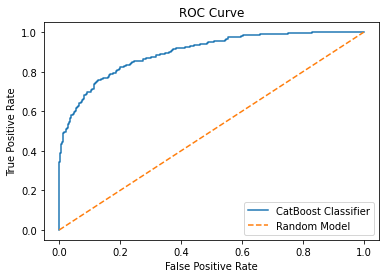

In [276]:
# Plotting the ROC curve for our best model

probs = model_cb.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(target_test, probs[:,1])
plt.figure()
plt.plot(fpr, tpr, label='CatBoost Classifier')
plt.plot([0,1],[0,1], linestyle='--', label='Random Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc ="lower right")
plt.title('ROC Curve')
plt.show()

This model performs much better than a random model and we got a final AUC ROC score of 0.90 on the test set, slightly less than on the validation set due probably to some overfitting, but still a very good score.

## Conclusion

We had three datasets of 7043 customers, two of the datasets having less since not all customers got the internet or phone options in their contracts. No problematic entries were found apart from 11 missing entries in `total_charges` which were deleted, `begin_month` and `begin_year` variables were added but not a starting day as it is always on the first of each month, and `contract_length` was calculated and added to the table. All the tables were merged which added missing values since not all customers had subscribed to phone and internet services, and those were filled with either 'No' or 'N/A' depending on the context.

We saw that people who terminated their contract had higher monthly charges, it might be helpful to propose a cheaper plan to people on the verge of leaving then.
A lot of people stop their contract after just one month, so it might be interesting to send in new offers just before that first month renews to make sure they keep their plan. Efforts to retain customers should be concentrated on people that have been on their contract for less than 5 months, or for more than 65 months. Customers leaving increased each year with a sharper increase in the last year.
Most people prefer the month-to-month option and electronic checks, but these options had the highest percentage of customers leaving, while the two-year contract, and other payment methods had the highest percentage of people staying, so these should be encouraged when proposing new contracts. Fiber optic was the most popular option for internet, but also the one with the biggest percentage of people leaving.

We then split our data into features and target variables, dropped non-needed columns for the models, and preprocessed the data with either a preprocessor with one hot encoding and numerical scaling for logistic regression, or ordinal encoding for tree based algorithms. We evaluated our models against a baseline model made of a constant classifier that always predicts 1. The following models were tested: Logistic Regression, Random Forests, CatBoost Classifier. The following methods for dealing with class weight imbalance were used: balanced class weight parameter, over-sampling using SMOTE (Synthetic Minority Oversampling Technique) from the imbalanced-learn Python library, or combining over- and under-sampling using SMOTETomek from the same library. CatBoost Classifier performed best with a final ROC AUC score on the test set of 0.90.